In [26]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from typing import NamedTuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils.corr import auto_correlation_matrix, get_significant_correlations
from utils.tableone import compute_tableone, filter_tableone
from utils.plots import (
    BarHConfig, plot_top_n_barh,
    ParetoConfig, plot_pareto_curve,
    ScatterConfig, plot_scatter,
    HistConfig, plot_hist
)

PROJECT_PATH = Path('.').absolute().parents[0]
DATA_PATH = Path(PROJECT_PATH, 'raw')

print('Project path: ', PROJECT_PATH)
print('Data path: ', DATA_PATH)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project path:  /Users/taehyun/project/side-projects/data/dunnhumby
Data path:  /Users/taehyun/project/side-projects/data/dunnhumby/raw


# Exploration for Dunnhumby The-Complete-Journey

## Table

**Data table**
- campaign_table
- transaction_data
- hh_demographic

**Lookup table**
- campaign_desc
- coupon
- coupon_redempt
- product


```
hh_demographic ──┐
                 │
                 ├─→ transaction_data ←─→ product
                 │         ↓
campaign_table ──┘         ↓
      ↓              causal_data
campaign_desc
      ↓
    coupon ←──→ coupon_redempt
```

---

## Table of Contents

3. [Product Analysis](#3.-Product-Analysis)
   - 3.1 Data Loading & Overview
   - 3.2 Product Hierarchy & Distribution
   - 3.3 Popular Products & Repeat Purchase
   - 3.4 Product Concentration (Long-tail)
   - 3.5 Customer-Category Relationship
   - 3.6 Price Analysis
   - 3.7 Discount Patterns

## Exploration

#### 3.1 Data Loading & Overview

In [27]:
df_product = pd.read_csv(DATA_PATH / 'product.csv')
df_trans = pd.read_csv(DATA_PATH / 'transaction_data.csv')

# Clean transaction data (same as exploration_1)
# - Remove outliers: QUANTITY == 0 and RETAIL_DISC > 0 (floating point artifacts)
df_trans = df_trans[(df_trans['QUANTITY'] > 0) & (df_trans['RETAIL_DISC'] <= 0)]

# Negate discount columns (stored as negative in raw data)
df_trans = df_trans.assign(**{
    'COUPON_MATCH_DISC': -df_trans['COUPON_MATCH_DISC'],
    'COUPON_DISC': -df_trans['COUPON_DISC'],
    'RETAIL_DISC': -df_trans['RETAIL_DISC']
})

# Derived columns (formulas adjusted for negated discount values)
# Reference: dunnhumby User Guide p.3
# - SHELF_PRICE: original shelf price before any discount (adds back retail_disc + coupon_match_disc)
# - UNIT_PRICE: price per unit charged to customer (sales_value / quantity)
# - ACTUAL_SPENT: what customer actually paid (subtracts coupon_disc from sales_value)
df_trans = df_trans.assign(**{
    'SHELF_PRICE': lambda x: (x['SALES_VALUE'] + x['RETAIL_DISC'] + x['COUPON_MATCH_DISC']) / x['QUANTITY'],
    'UNIT_PRICE': lambda x: x['SALES_VALUE'] / x['QUANTITY'],
    'ACTUAL_SPENT': lambda x: x['SALES_VALUE'] - x['COUPON_DISC']
})

print(f"Total products in catalog: {len(df_product):,}")
print(f"Products with transactions: {df_trans['PRODUCT_ID'].nunique():,}")
print(f"Total transactions: {len(df_trans):,}")
print(f"\nProduct columns: {df_product.columns.tolist()}")
df_product.head(10)

Total products in catalog: 92,353
Products with transactions: 92,015
Total transactions: 2,581,260

Product columns: ['PRODUCT_ID', 'MANUFACTURER', 'DEPARTMENT', 'BRAND', 'COMMODITY_DESC', 'SUB_COMMODITY_DESC', 'CURR_SIZE_OF_PRODUCT']


,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ
5,26426,69,GROCERY,Private,SPICES & EXTRACTS,SPICES & SEASONINGS,2.5 OZ
6,26540,69,GROCERY,Private,COOKIES/CONES,TRAY PACK/CHOC CHIP COOKIES,16 OZ
7,26601,69,DRUG GM,Private,VITAMINS,VITAMIN - MINERALS,300CT(1)
8,26636,69,PASTRY,Private,BREAKFAST SWEETS,SW GDS: SW ROLLS/DAN,
9,26691,16,GROCERY,Private,PNT BTR/JELLY/JAMS,HONEY,12 OZ


In [28]:
# Basic statistics
df_product.describe(include='all')

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
count,9.235300e+04,92353.00000,92353,92353,92353,92353,92353
unique,NaN,NaN,44,2,308,2383,4345
top,NaN,NaN,GROCERY,National,GREETING CARDS/WRAP/PARTY SPLY,CARDS EVERYDAY,
freq,NaN,NaN,39021,78537,2785,1005,30607
mean,5.328353e+06,1739.22833,NaN,NaN,NaN,NaN,NaN
std,5.359937e+06,1818.26957,NaN,NaN,NaN,NaN,NaN
min,2.567100e+04,1.00000,NaN,NaN,NaN,NaN,NaN
25%,9.706280e+05,328.00000,NaN,NaN,NaN,NaN,NaN
50%,1.621091e+06,1094.00000,NaN,NaN,NaN,NaN,NaN
75%,9.704770e+06,2264.00000,NaN,NaN,NaN,NaN,NaN


In [29]:
# Null value check
df_product.isnull().sum().to_frame('null_count').assign(
    null_pct=lambda x: (x['null_count'] / len(df_product) * 100).round(2)
).T

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
null_count,0.0,0.0,0.0,0.0,0.0,0.0,0.0
null_pct,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 3.2 Product Hierarchy & Distribution

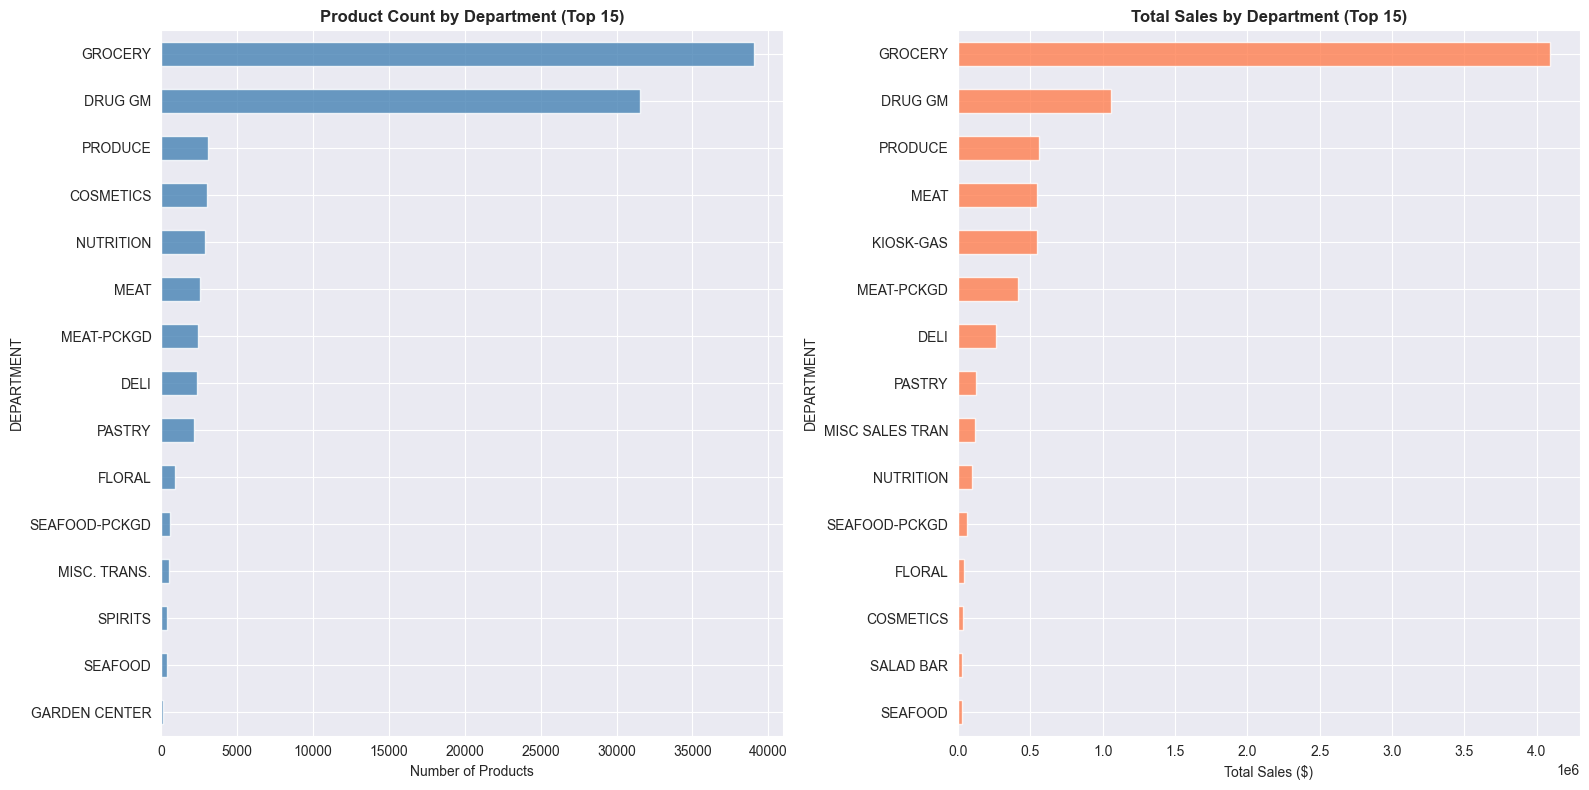


DEPARTMENT SUMMARY (Top 15 by Sales)
| DEPARTMENT      |   n_products |   n_transactions |      total_sales |   total_quantity |   avg_price |   sales_per_product |
|:----------------|-------------:|-----------------:|-----------------:|-----------------:|------------:|--------------------:|
| GROCERY         |        38982 |       1.6435e+06 |      4.09381e+06 |      2.19476e+06 |        1.87 |              105.02 |
| DRUG GM         |        31385 |  275887          |      1.05535e+06 | 353830           |        2.98 |               33.63 |
| PRODUCE         |         3092 |  255906          | 557438           | 319993           |        1.74 |              180.28 |
| MEAT            |         2541 |   88248          | 548786           | 119113           |        4.61 |              215.97 |
| KIOSK-GAS       |           16 |   22059          | 544222           |      2.21255e+08 |        0    |            34013.9  |
| MEAT-PCKGD      |         2427 |  111730          | 412426      

In [30]:
# Department distribution using utils/plots.py
df_trans_product = df_trans.merge(df_product, on='PRODUCT_ID', how='left')

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Left: Product count by department
dept_product_counts = df_product['DEPARTMENT'].value_counts()
config1 = BarHConfig(title='Product Count by Department (Top 15)', xlabel='Number of Products', color='steelblue', n=15)
plot_top_n_barh(axes[0], dept_product_counts, config1)

# Right: Sales value by department
dept_sales = (
    df_trans_product
    .groupby('DEPARTMENT')['SALES_VALUE']
    .sum()
    .sort_values(ascending=False)
)
config2 = BarHConfig(title='Total Sales by Department (Top 15)', xlabel='Total Sales ($)', color='coral', n=15)
plot_top_n_barh(axes[1], dept_sales, config2)

plt.tight_layout()
plt.show()

# Summary table
dept_summary = (
    df_trans_product
    .groupby('DEPARTMENT')
    .agg(
        n_products=('PRODUCT_ID', 'nunique'),
        n_transactions=('PRODUCT_ID', 'count'),
        total_sales=('SALES_VALUE', 'sum'),
        total_quantity=('QUANTITY', 'sum')
    )
    .assign(
        avg_price=lambda x: x['total_sales'] / x['total_quantity'],
        sales_per_product=lambda x: x['total_sales'] / x['n_products']
    )
    .sort_values('total_sales', ascending=False)
)

print("\n" + "="*80)
print("DEPARTMENT SUMMARY (Top 15 by Sales)")
print("="*80)
print(dept_summary.head(15).round(2).to_markdown())

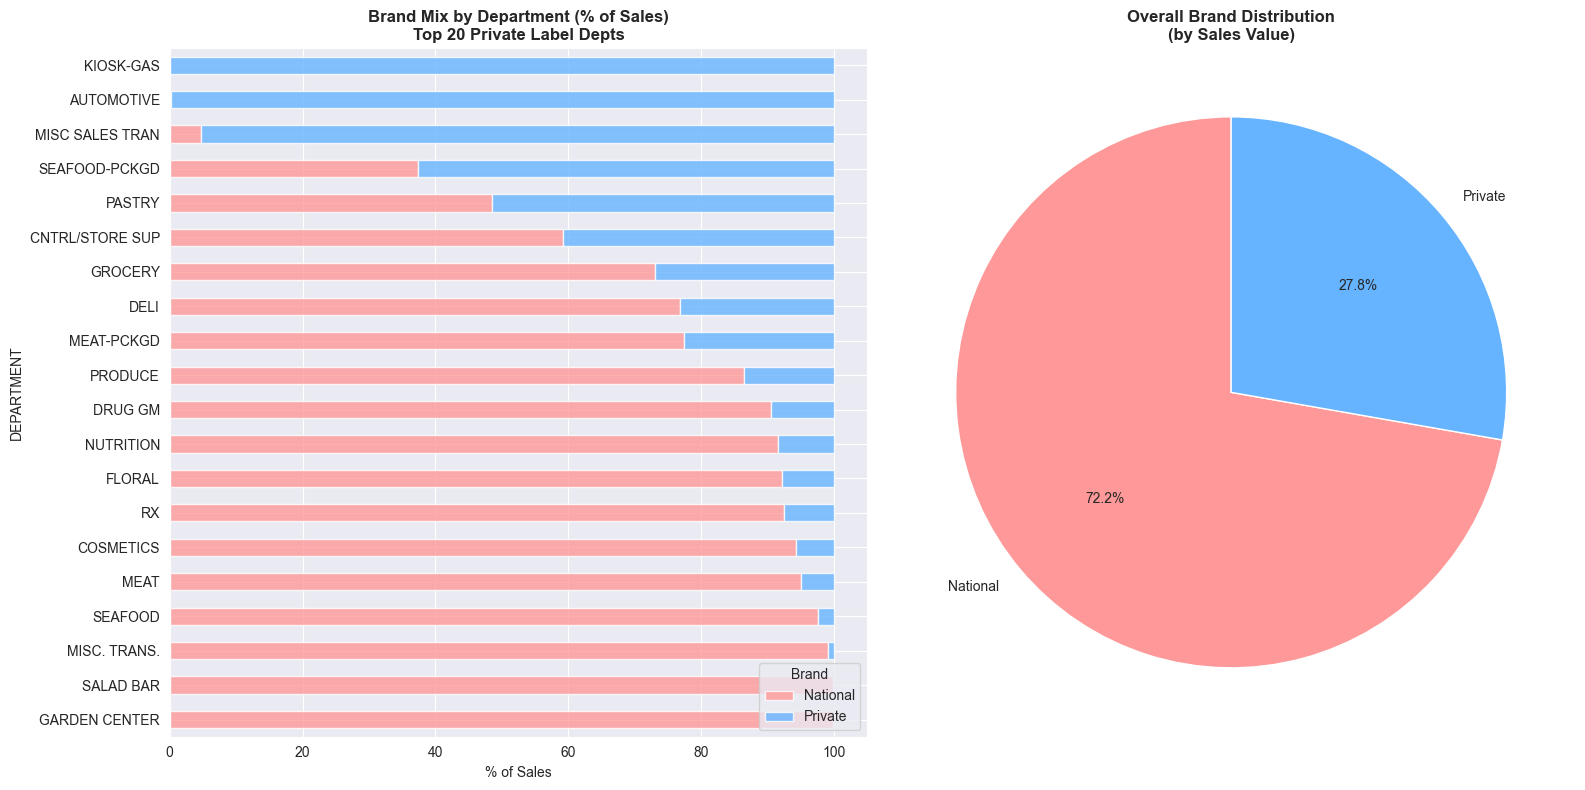


PRIVATE LABEL PENETRATION BY DEPARTMENT

Departments with >50% Private Label: 5
Departments with <20% Private Label: 34

Top 5 Private Label Departments:
| DEPARTMENT      |   Private Label % |
|:----------------|------------------:|
| KIOSK-GAS       |             100   |
| AUTOMOTIVE      |              99.8 |
| MISC SALES TRAN |              95.3 |
| SEAFOOD-PCKGD   |              62.6 |
| PASTRY          |              51.6 |


In [31]:
# Brand distribution: National vs Private by Department (Sales-weighted)
brand_sales = (
    df_trans_product
    .groupby(['DEPARTMENT', 'BRAND'])['SALES_VALUE']
    .sum()
    .unstack(fill_value=0)
)

# Calculate percentages
brand_sales_pct = brand_sales.div(brand_sales.sum(axis=1), axis=0) * 100
brand_sales_pct = brand_sales_pct.sort_values('Private', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Left: Stacked bar chart (top 20 departments)
brand_sales_pct.head(20).plot(
    kind='barh', stacked=True, ax=axes[0],
    color=['#ff9999', '#66b3ff'], alpha=0.8
)
axes[0].set_title('Brand Mix by Department (% of Sales)\nTop 20 Private Label Depts', fontsize=12, fontweight='bold')
axes[0].set_xlabel('% of Sales')
axes[0].legend(title='Brand', loc='lower right')
axes[0].invert_yaxis()

# Right: Overall brand distribution (pie)
overall_brand = df_trans_product.groupby('BRAND')['SALES_VALUE'].sum()
overall_brand.plot(
    kind='pie', ax=axes[1], autopct='%1.1f%%',
    colors=['#ff9999', '#66b3ff'], startangle=90
)
axes[1].set_title('Overall Brand Distribution\n(by Sales Value)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

# Private label share summary
print("\n" + "="*60)
print("PRIVATE LABEL PENETRATION BY DEPARTMENT")
print("="*60)
private_share = brand_sales_pct['Private'].sort_values(ascending=False)
print(f"\nDepartments with >50% Private Label: {(private_share > 50).sum()}")
print(f"Departments with <20% Private Label: {(private_share < 20).sum()}")
print(f"\nTop 5 Private Label Departments:")
print(private_share.head(5).round(1).to_frame('Private Label %').to_markdown())

In [37]:
# Check for multiple commodities per product

df_product_cmdt_cnt = df_product[['PRODUCT_ID', 'COMMODITY_DESC']].groupby('PRODUCT_ID')['COMMODITY_DESC'].nunique().reset_index()
df_product_cmdt_cnt[df_product_cmdt_cnt['COMMODITY_DESC'] > 1]

,PRODUCT_ID,COMMODITY_DESC


Unique COMMODITY_DESC: 308
Unique SUB_COMMODITY_DESC: 2383
Unique MANUFACTURER: 6476


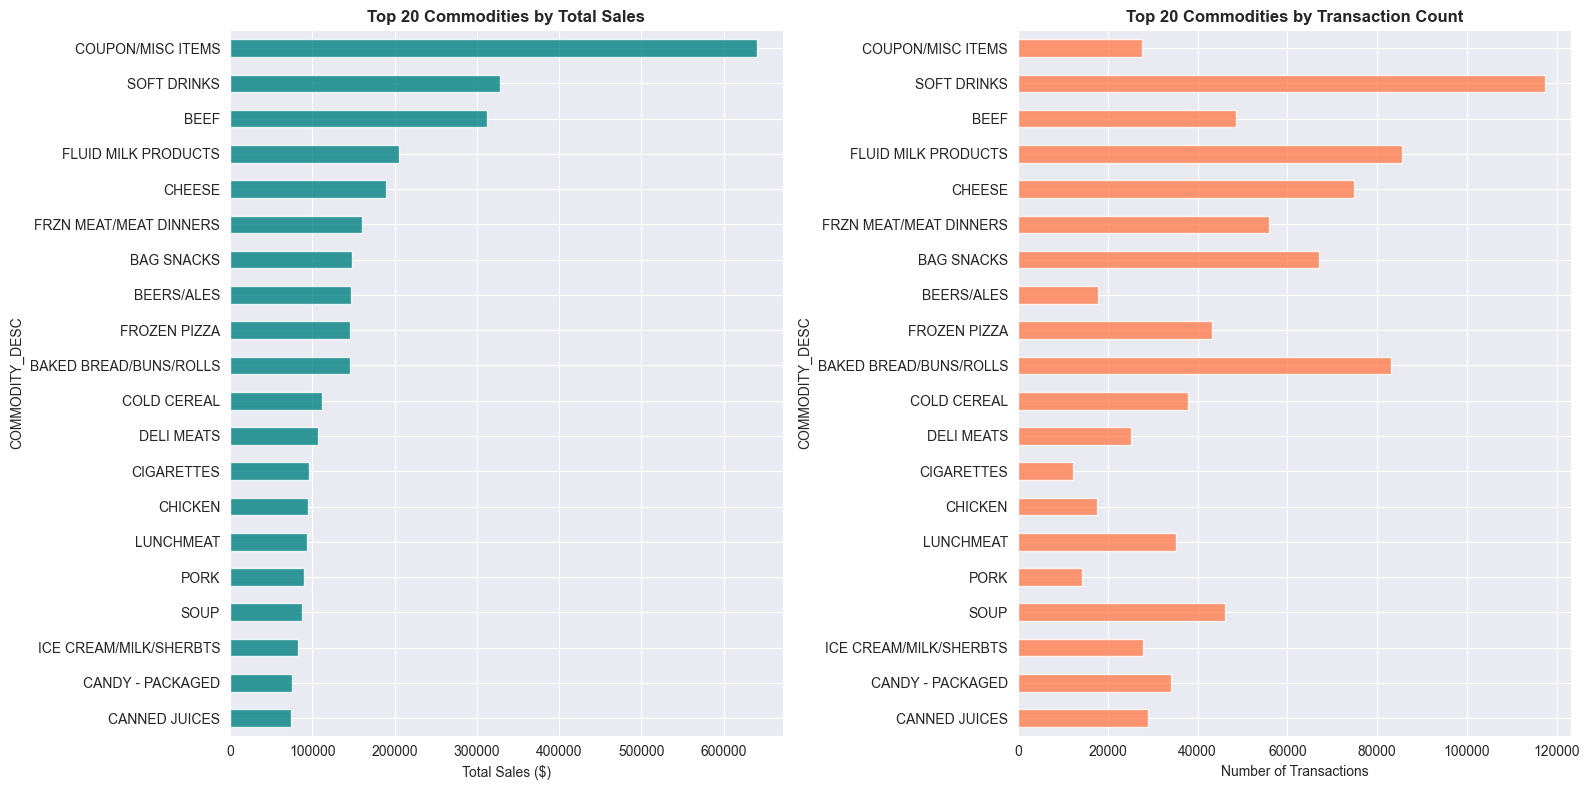


TOP 20 COMMODITIES BY SALES
| COMMODITY_DESC         |   n_products |   n_transactions |   total_sales |   total_quantity |   avg_price |
|:-----------------------|-------------:|-----------------:|--------------:|-----------------:|------------:|
| COUPON/MISC ITEMS      |          128 |            27710 |      639878   |      2.57218e+08 |        0    |
| SOFT DRINKS            |         1696 |           117216 |      327645   | 160637           |        2.04 |
| BEEF                   |         1109 |            48651 |      312103   |  65576           |        4.76 |
| FLUID MILK PRODUCTS    |          455 |            85502 |      205356   | 116192           |        1.77 |
| CHEESE                 |         1096 |            74821 |      189528   |  96402           |        1.97 |
| FRZN MEAT/MEAT DINNERS |         1268 |            55991 |      160517   |  79391           |        2.02 |
| BAG SNACKS             |         1521 |            67076 |      148375   |  80824        

In [32]:
# Commodity Analysis using utils/plots.py
print(f"Unique COMMODITY_DESC: {df_product['COMMODITY_DESCb'].nunique()}")
print(f"Unique SUB_COMMODITY_DESC: {df_product['SUB_COMMODITY_DESC'].nunique()}")
print(f"Unique MANUFACTURER: {df_product['MANUFACTURER'].nunique()}")

# Top commodities by sales
commodity_sales = (
    df_trans_product
    .groupby('COMMODITY_DESC')
    .agg(
        n_products=('PRODUCT_ID', 'nunique'),
        n_transactions=('PRODUCT_ID', 'count'),
        total_sales=('SALES_VALUE', 'sum'),
        total_quantity=('QUANTITY', 'sum')
    )
    .assign(avg_price=lambda x: x['total_sales'] / x['total_quantity'])
    .sort_values('total_sales', ascending=False)
)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

config1 = BarHConfig(title='Top 20 Commodities by Total Sales', xlabel='Total Sales ($)', color='teal', n=20)
plot_top_n_barh(axes[0], commodity_sales['total_sales'], config1)

config2 = BarHConfig(title='Top 20 Commodities by Transaction Count', xlabel='Number of Transactions', color='coral', n=20)
plot_topㅠ_n_barh(axes[1], commodity_sales['n_transactions'], config2)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("TOP 20 COMMODITIES BY SALES")
print("="*80)
print(commodity_sales.head(20).round(2).to_markdown())

In [39]:
df_product[df_product['COMMODITY_DESC'] == 'COUPON/MISC ITEMS']['SUB_COMMODITY_DESC'].drop_duplicates()

2820              GASOLINE-REG UNLEADED
3184                   MISC SALES TRANS
5666            PEYTON/GM EXPENSE ITEMS
5899     CAN DOG FOOD RATION (TRIX/VETS
6938     SOFT DRINKS CAN NON-CARB (EXCE
13038          MISCELLANEOUS H & B AIDS
15314                           TICKETS
16113              FLORAL DEPT KEY RING
19541                 DEA SCHEDULE C II
22384                        BULK CANDY
28726    ELECTRONIC GIFT CARDS ACTIVATI
31143             PRODUCE DEPT KEY RING
31935                     MEAT SUPPLIES
39914               MISC. BATH PRODUCTS
41357     ELECTRONIC GIFT CARDS REFRESH
47397                         DONATIONS
59612                  CENTRAL SUPPLIES
66159        OUTSIDE VENDORS GIFT CARDS
78400    COFF SHOP: RETAIL PACK BEVERAG
78712        AMERICAN EXPRESS GIFT CARD
78959              MASTERCARD GIFT CARD
86113                             JUICE
Name: SUB_COMMODITY_DESC, dtype: object

In [43]:
# Product hierarchy summary by department
dept_hierarchy_summary = (
    df_product
    .groupby('DEPARTMENT')
    .agg(
        n_commodities=('COMMODITY_DESC', 'nunique'),
        n_sub_commodities=('SUB_COMMODITY_DESC', 'nunique'),
        n_products=('PRODUCT_ID', 'count'),
        n_manufacturers=('MANUFACTURER', 'nunique')
    )
    .sort_values('n_products', ascending=False)
)

# Add sales data
dept_sales_data = (
    df_trans_product
    .groupby('DEPARTMENT')
    .agg(total_sales=('SALES_VALUE', 'sum'))
)

dept_hierarchy_summary = dept_hierarchy_summary.join(dept_sales_data)
dept_hierarchy_summary = dept_hierarchy_summary.assign(
    sales_per_product=lambda x: x['total_sales'] / x['n_products']
).sort_values('total_sales', ascending=False)

print("="*80)
print("DEPARTMENT HIERARCHY SUMMARY")
print("="*80)
print(dept_hierarchy_summary.head(15).round(2).to_markdown())

DEPARTMENT HIERARCHY SUMMARY
| DEPARTMENT      |   n_commodities |   n_sub_commodities |   n_products |   n_manufacturers |      total_sales |   sales_per_product |
|:----------------|----------------:|--------------------:|-------------:|------------------:|-----------------:|--------------------:|
| GROCERY         |              94 |                 736 |        39021 |              1527 |      4.09381e+06 |              104.91 |
| DRUG GM         |              91 |                 894 |        31529 |              1985 |      1.05535e+06 |               33.47 |
| PRODUCE         |              32 |                 202 |         3118 |               252 | 557438           |              178.78 |
| MEAT            |              15 |                 161 |         2544 |              1033 | 548786           |              215.72 |
| KIOSK-GAS       |               2 |                   1 |           16 |                 1 | 544222           |            34013.9  |
| MEAT-PCKGD      |

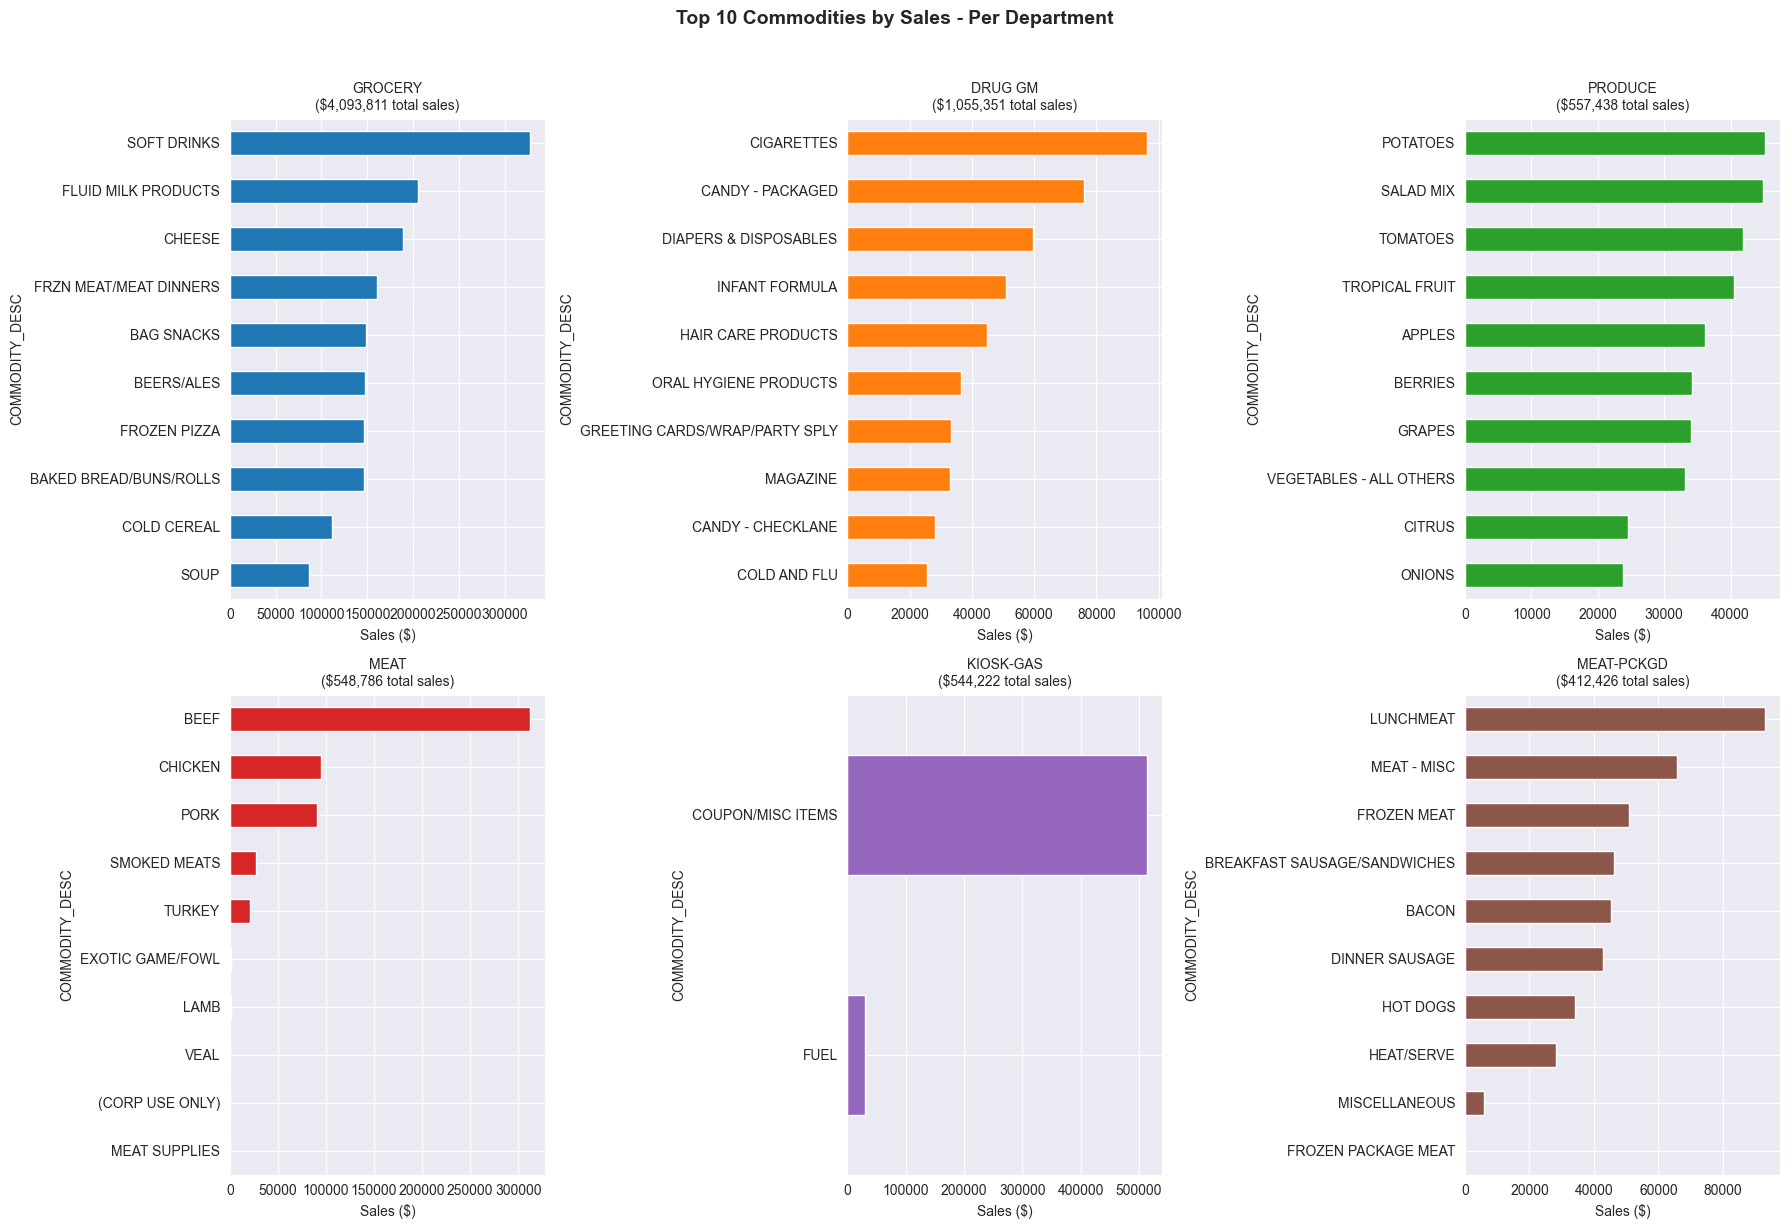

In [45]:
# Top commodities per department (treemap-style view)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

top_depts = dept_hierarchy_summary.head(6).index.tolist()

for idx, dept in enumerate(top_depts):
    dept_commodity_sales = (
        df_trans_product[df_trans_product['DEPARTMENT'] == dept]
        .groupby('COMMODITY_DESC')['SALES_VALUE']
        .sum()
        .sort_values(ascending=False)
        .head(10)
    )
    dept_commodity_sales.plot(kind='barh', ax=axes[idx], color=plt.cm.tab10(idx))
    axes[idx].set_title(f'{dept}\n(${dept_hierarchy_summary.loc[dept, "total_sales"]:,.0f} total sales)', fontsize=10)
    axes[idx].invert_yaxis()
    axes[idx].set_xlabel('Sales ($)')

plt.suptitle('Top 10 Commodities by Sales - Per Department', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

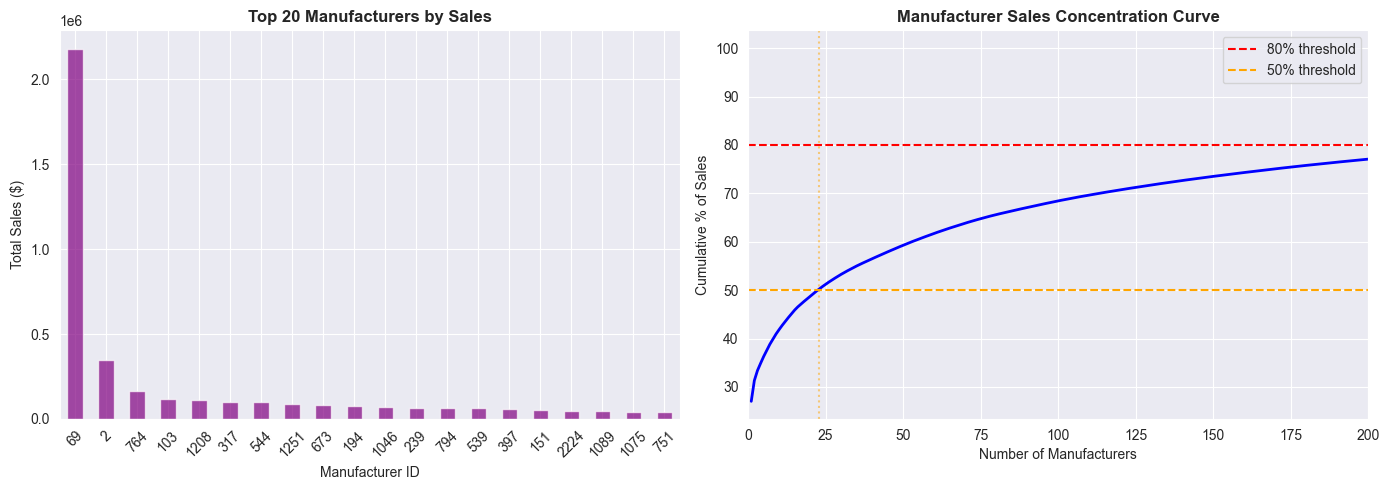

MANUFACTURER CONCENTRATION (Sales-weighted)
Total manufacturers with sales: 6,453
Top 23 manufacturers account for 50% of sales
Top 255 manufacturers account for 80% of sales

Top 10 Manufacturers:
|   MANUFACTURER |   n_products |   n_transactions |      total_sales |
|---------------:|-------------:|-----------------:|-----------------:|
|             69 |        12667 |           730857 |      2.17843e+06 |
|              2 |         1345 |           169150 | 346804           |
|            764 |         1331 |            31209 | 165212           |
|            103 |          533 |            37807 | 119344           |
|           1208 |          445 |            34655 | 114565           |
|            317 |          669 |            39303 | 102558           |
|            544 |          913 |            46026 | 101304           |
|           1251 |          685 |            35449 |  86470.9         |
|            673 |          680 |            26246 |  84947.2         |
|         

In [44]:
# Manufacturer concentration analysis (Sales-weighted)
manufacturer_sales = (
    df_trans_product
    .groupby('MANUFACTURER')
    .agg(
        n_products=('PRODUCT_ID', 'nunique'),
        n_transactions=('PRODUCT_ID', 'count'),
        total_sales=('SALES_VALUE', 'sum')
    )
    .sort_values('total_sales', ascending=False)
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Top 20 manufacturers by sales
manufacturer_sales.head(20)['total_sales'].plot(kind='bar', ax=axes[0], color='purple', alpha=0.7)
axes[0].set_title('Top 20 Manufacturers by Sales', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Manufacturer ID')
axes[0].set_ylabel('Total Sales ($)')
axes[0].tick_params(axis='x', rotation=45)

# Manufacturer concentration (cumulative sales)
cumsum_sales_pct = (manufacturer_sales['total_sales'].cumsum() / manufacturer_sales['total_sales'].sum() * 100)
axes[1].plot(range(1, len(cumsum_sales_pct) + 1), cumsum_sales_pct.values, 'b-', linewidth=2)
axes[1].axhline(y=80, color='r', linestyle='--', label='80% threshold')
axes[1].axhline(y=50, color='orange', linestyle='--', label='50% threshold')

n_for_80 = (cumsum_sales_pct <= 80).sum() + 1
n_for_50 = (cumsum_sales_pct <= 50).sum() + 1
axes[1].axvline(x=n_for_80, color='r', linestyle=':', alpha=0.5)
axes[1].axvline(x=n_for_50, color='orange', linestyle=':', alpha=0.5)

axes[1].set_xlabel('Number of Manufacturers')
axes[1].set_ylabel('Cumulative % of Sales')
axes[1].set_title('Manufacturer Sales Concentration Curve', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].set_xlim(0, 200)

plt.tight_layout()
plt.show()

print("="*60)
print("MANUFACTURER CONCENTRATION (Sales-weighted)")
print("="*60)
print(f"Total manufacturers with sales: {len(manufacturer_sales):,}")
print(f"Top {n_for_50} manufacturers account for 50% of sales")
print(f"Top {n_for_80} manufacturers account for 80% of sales")
print(f"\nTop 10 Manufacturers:")
print(manufacturer_sales.head(10).round(2).to_markdown())

**Summary: Product Hierarchy & Distribution**
- **92,353 products** in catalog (92,015 with transactions)
- **Hierarchy:** 44 departments → 308 commodities → 2,383 sub-commodities
- **Top departments:** GROCERY ($4.1M, 51%), DRUG GM ($1.1M), PRODUCE ($557K), MEAT ($549K)
- **Brand mix:** 85% National, 15% Private label
  - High Private Label: PASTRY (64%), DELI (46%), MEAT-PCKGD (42%)
  - Low Private Label: COSMETICS (1%), VIDEO (2%), PHOTO (3%)
- **Manufacturer concentration:** Top 57 (1.5%) account for 80% of sales

#### 3.3 Popular Products & Repeat Purchase

In [46]:
# Popular products by sales and transaction frequency
product_sales = (
    df_trans_product
    .groupby(['PRODUCT_ID', 'DEPARTMENT', 'COMMODITY_DESC', 'BRAND'])
    .agg(
        n_transactions=('PRODUCT_ID', 'size'),
        n_households=('household_key', 'nunique'),
        total_sales=('SALES_VALUE', 'sum'),
        total_quantity=('QUANTITY', 'sum')
    )
    .assign(
        avg_price=lambda x: x['total_sales'] / x['total_quantity'],
        sales_per_household=lambda x: x['total_sales'] / x['n_households']
    )
    .reset_index()
    .sort_values('total_sales', ascending=False)
)

print("="*60)
print("TOP 20 PRODUCTS BY TOTAL SALES")
print("="*60)
print(product_sales.head(20)[['PRODUCT_ID', 'DEPARTMENT', 'COMMODITY_DESC', 'n_transactions', 'n_households', 'total_sales']].to_markdown(index=False))

print("\n" + "="*60)
print("TOP 20 PRODUCTS BY HOUSEHOLD REACH")
print("="*60)
product_by_reach = product_sales.sort_values('n_households', ascending=False)
print(product_by_reach.head(20)[['PRODUCT_ID', 'DEPARTMENT', 'COMMODITY_DESC', 'n_households', 'total_sales']].to_markdown(index=False))

TOP 20 PRODUCTS BY TOTAL SALES
|   PRODUCT_ID | DEPARTMENT      | COMMODITY_DESC         |   n_transactions |   n_households |   total_sales |
|-------------:|:----------------|:-----------------------|-----------------:|---------------:|--------------:|
|      6534178 | KIOSK-GAS       | COUPON/MISC ITEMS      |            19820 |           1312 |      503867   |
|      6533889 | MISC SALES TRAN | COUPON/MISC ITEMS      |             1453 |            151 |       46311.3 |
|      1029743 | GROCERY         | FLUID MILK PRODUCTS    |            14405 |           1385 |       41072.1 |
|      6534166 | MISC SALES TRAN | COUPON/MISC ITEMS      |             1206 |            189 |       33594.5 |
|      1082185 | PRODUCE         | TROPICAL FRUIT         |            29757 |           2069 |       29481.4 |
|       916122 | MEAT            | CHICKEN                |             4409 |           1154 |       28951.9 |
|      6533765 | KIOSK-GAS       | FUEL                   |             1

In [47]:
# Repeated purchase analysis: How many households repurchase products?
product_repurchase = (
    df_trans_product
    .groupby(['PRODUCT_ID', 'household_key'])
    .agg(purchase_count=('PRODUCT_ID', 'size'))
    .reset_index()
)

# Products with repeat purchasers
product_repeat_stats = (
    product_repurchase
    .assign(is_repeat=lambda x: (x['purchase_count'] > 1).astype(int))
    .groupby('PRODUCT_ID')
    .agg(
        total_buyers=('household_key', 'nunique'),
        repeat_buyers=('is_repeat', 'sum'),
        avg_purchases_per_buyer=('purchase_count', 'mean')
    )
    .assign(repeat_rate=lambda x: x['repeat_buyers'] / x['total_buyers'])
    .sort_values('total_buyers', ascending=False)
)

# Merge with product info
product_repeat_stats = product_repeat_stats.reset_index().merge(
    df_product[['PRODUCT_ID', 'DEPARTMENT', 'COMMODITY_DESC', 'BRAND']],
    on='PRODUCT_ID'
)

print("="*60)
print("REPEAT PURCHASE STATISTICS")
print("="*60)
print(f"Products with any repeat buyers: {(product_repeat_stats['repeat_rate'] > 0).sum():,} ({(product_repeat_stats['repeat_rate'] > 0).mean()*100:.1f}%)")
print(f"Products with >50% repeat rate: {(product_repeat_stats['repeat_rate'] > 0.5).sum():,}")
print(f"\nOverall avg repeat rate: {product_repeat_stats['repeat_rate'].mean():.1%}")
print(f"Overall avg purchases per buyer: {product_repeat_stats['avg_purchases_per_buyer'].mean():.2f}")

# Top products by repeat rate (min 50 buyers)
print("\n" + "="*60)
print("TOP 20 PRODUCTS BY REPEAT RATE (min 50 buyers)")
print("="*60)
top_repeat = (
    product_repeat_stats[product_repeat_stats['total_buyers'] >= 50]
    .sort_values('repeat_rate', ascending=False)
    .head(20)
)
print(top_repeat[['PRODUCT_ID', 'DEPARTMENT', 'COMMODITY_DESC', 'total_buyers', 'repeat_rate', 'avg_purchases_per_buyer']].to_markdown(index=False))

REPEAT PURCHASE STATISTICS
Products with any repeat buyers: 36,019 (39.1%)
Products with >50% repeat rate: 4,806

Overall avg repeat rate: 13.3%
Overall avg purchases per buyer: 1.33

TOP 20 PRODUCTS BY REPEAT RATE (min 50 buyers)
|   PRODUCT_ID | DEPARTMENT   | COMMODITY_DESC         |   total_buyers |   repeat_rate |   avg_purchases_per_buyer |
|-------------:|:-------------|:-----------------------|---------------:|--------------:|--------------------------:|
|      1082185 | PRODUCE      | TROPICAL FRUIT         |           2069 |      0.869019 |                  14.3823  |
|      6534178 | KIOSK-GAS    | COUPON/MISC ITEMS      |           1312 |      0.786585 |                  15.1067  |
|      1029743 | GROCERY      | FLUID MILK PRODUCTS    |           1385 |      0.758845 |                  10.4007  |
|      1106523 | GROCERY      | FLUID MILK PRODUCTS    |           1037 |      0.750241 |                   9.44166 |
|       981760 | GROCERY      | EGGS                   |     

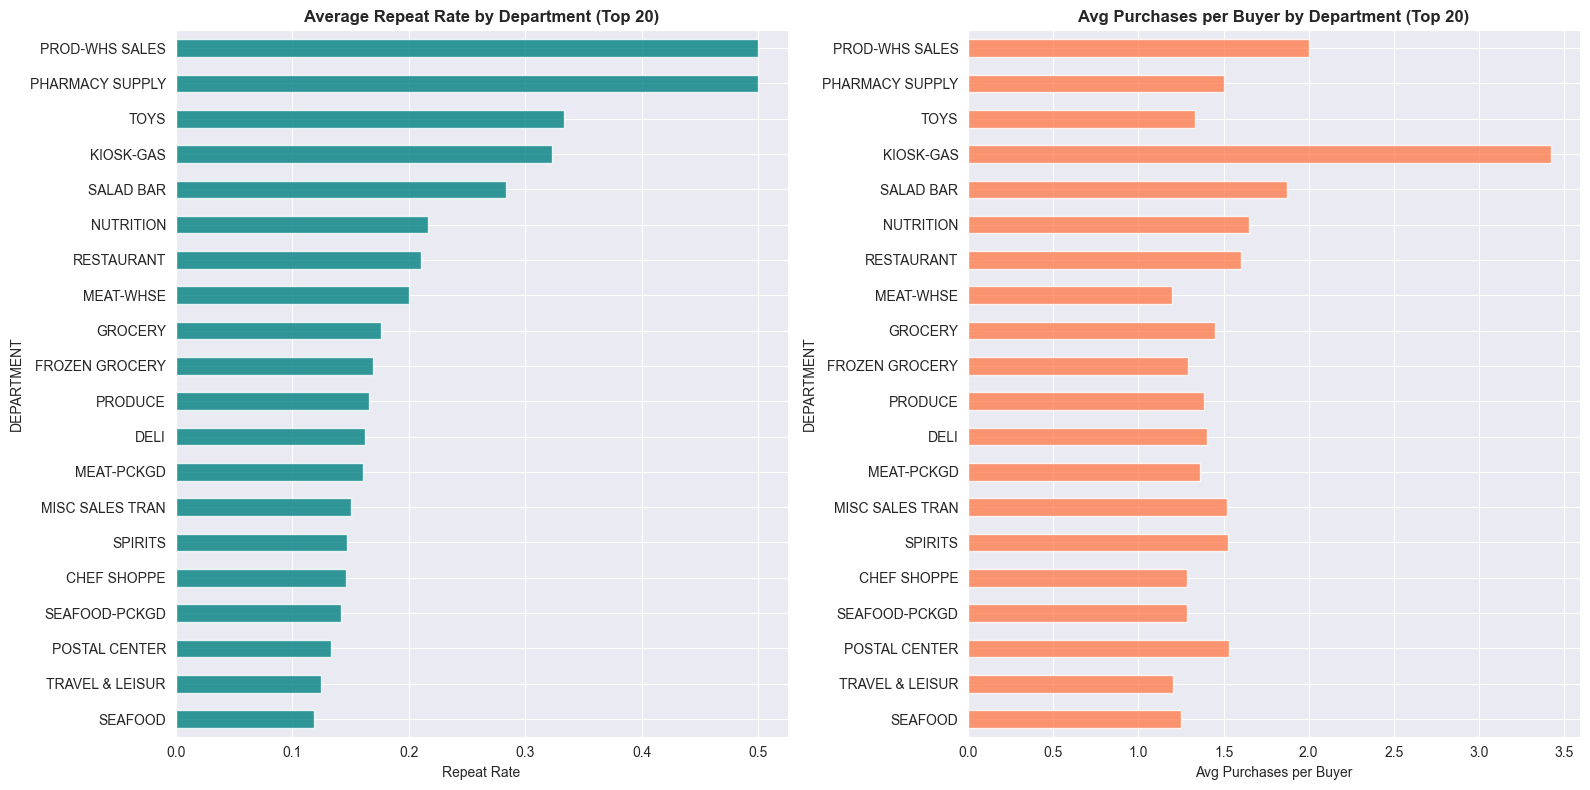

REPEAT PURCHASE BY DEPARTMENT (Top 15)
| DEPARTMENT      |   n_products |   avg_repeat_rate |   avg_purchases_per_buyer |   total_buyers |
|:----------------|-------------:|------------------:|--------------------------:|---------------:|
| PROD-WHS SALES  |            2 |             0.5   |                     2     |              2 |
| PHARMACY SUPPLY |            1 |             0.5   |                     1.5   |              4 |
| TOYS            |            3 |             0.333 |                     1.333 |              4 |
| KIOSK-GAS       |           16 |             0.323 |                     3.422 |           1837 |
| SALAD BAR       |           46 |             0.283 |                     1.872 |           2976 |
| NUTRITION       |         2909 |             0.217 |                     1.649 |          17448 |
| RESTAURANT      |           98 |             0.21  |                     1.605 |            243 |
| MEAT-WHSE       |            1 |             0.2   |       

In [48]:
# Repeat rate by Department using utils/plots.py
dept_repeat = (
    product_repeat_stats
    .groupby('DEPARTMENT')
    .agg(
        n_products=('PRODUCT_ID', 'nunique'),
        avg_repeat_rate=('repeat_rate', 'mean'),
        avg_purchases_per_buyer=('avg_purchases_per_buyer', 'mean'),
        total_buyers=('total_buyers', 'sum')
    )
    .sort_values('avg_repeat_rate', ascending=False)
)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

config1 = BarHConfig(title='Average Repeat Rate by Department (Top 20)', xlabel='Repeat Rate', color='teal', n=20)
plot_top_n_barh(axes[0], dept_repeat['avg_repeat_rate'], config1)

config2 = BarHConfig(title='Avg Purchases per Buyer by Department (Top 20)', xlabel='Avg Purchases per Buyer', color='coral', n=20)
plot_top_n_barh(axes[1], dept_repeat['avg_purchases_per_buyer'], config2)

plt.tight_layout()
plt.show()

print("="*60)
print("REPEAT PURCHASE BY DEPARTMENT (Top 15)")
print("="*60)
print(dept_repeat.head(15).round(3).to_markdown())

**Summary: Popular Products & Repeat Purchase**
- **Top products by sales:** KIOSK-GAS (fuel), FLUID MILK, SOFT DRINKS
- **Highest household reach:** Staples like TROPICAL FRUIT, EGGS, FLUID MILK, BREAD
- **Repeat purchase:** 39% of products have repeat buyers; avg repeat rate 13%
- **High-repeat categories:** Consumables (MILK 87%, EGGS 74%, BREAD 68%)
- **Low-repeat categories:** Durables (COSMETICS, PHOTO, VIDEO)

#### 3.4 Product Concentration (Long-tail)

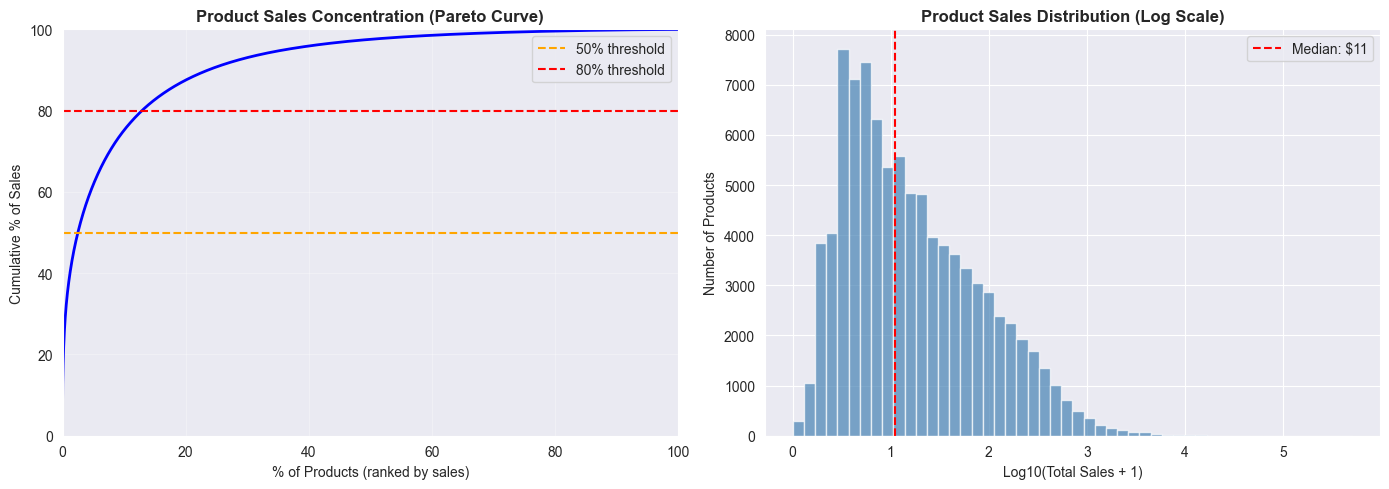

PRODUCT CONCENTRATION ANALYSIS

Total products with sales: 92,015

50% of sales from top 2,295 products (2.5%)
80% of sales from top 11,865 products (12.9%)

Median product sales: $10.98
Mean product sales: $87.57


In [49]:
# Product sales concentration (Pareto analysis) using utils/plots.py
product_sales_sorted = product_sales.sort_values('total_sales', ascending=False).reset_index(drop=True)
product_sales_sorted = product_sales_sorted.assign(
    cumsum_sales=lambda x: x['total_sales'].cumsum(),
    cumsum_pct=lambda x: x['total_sales'].cumsum() / x['total_sales'].sum() * 100,
    product_rank=lambda x: range(1, len(x) + 1),
    product_pct=lambda x: x['product_rank'] / len(x) * 100
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pareto curve using utils/plots.py
pareto_config = ParetoConfig(
    title='Product Sales Concentration (Pareto Curve)',
    xlabel='% of Products (ranked by sales)',
    ylabel='Cumulative % of Sales',
    thresholds=(50, 80),
    threshold_colors=('orange', 'red')
)
plot_pareto_curve(axes[0], product_sales_sorted['cumsum_pct'], pareto_config)

# Sales distribution (log scale)
axes[1].hist(np.log10(product_sales_sorted['total_sales'] + 1), bins=50, color='steelblue', alpha=0.7, edgecolor='white')
axes[1].set_xlabel('Log10(Total Sales + 1)')
axes[1].set_ylabel('Number of Products')
axes[1].set_title('Product Sales Distribution (Log Scale)', fontsize=12, fontweight='bold')
axes[1].axvline(np.log10(product_sales_sorted['total_sales'].median()), color='red', linestyle='--', 
                label=f'Median: ${product_sales_sorted["total_sales"].median():.0f}')
axes[1].legend()

plt.tight_layout()
plt.show()

# Find thresholds
pct_for_80_sales = product_sales_sorted[product_sales_sorted['cumsum_pct'] >= 80]['product_pct'].iloc[0]
pct_for_50_sales = product_sales_sorted[product_sales_sorted['cumsum_pct'] >= 50]['product_pct'].iloc[0]
n_for_80_sales = product_sales_sorted[product_sales_sorted['cumsum_pct'] >= 80]['product_rank'].iloc[0]
n_for_50_sales = product_sales_sorted[product_sales_sorted['cumsum_pct'] >= 50]['product_rank'].iloc[0]

print("="*60)
print("PRODUCT CONCENTRATION ANALYSIS")
print("="*60)
print(f"\nTotal products with sales: {len(product_sales_sorted):,}")
print(f"\n50% of sales from top {n_for_50_sales:,} products ({pct_for_50_sales:.1f}%)")
print(f"80% of sales from top {n_for_80_sales:,} products ({pct_for_80_sales:.1f}%)")
print(f"\nMedian product sales: ${product_sales_sorted['total_sales'].median():.2f}")
print(f"Mean product sales: ${product_sales_sorted['total_sales'].mean():.2f}")

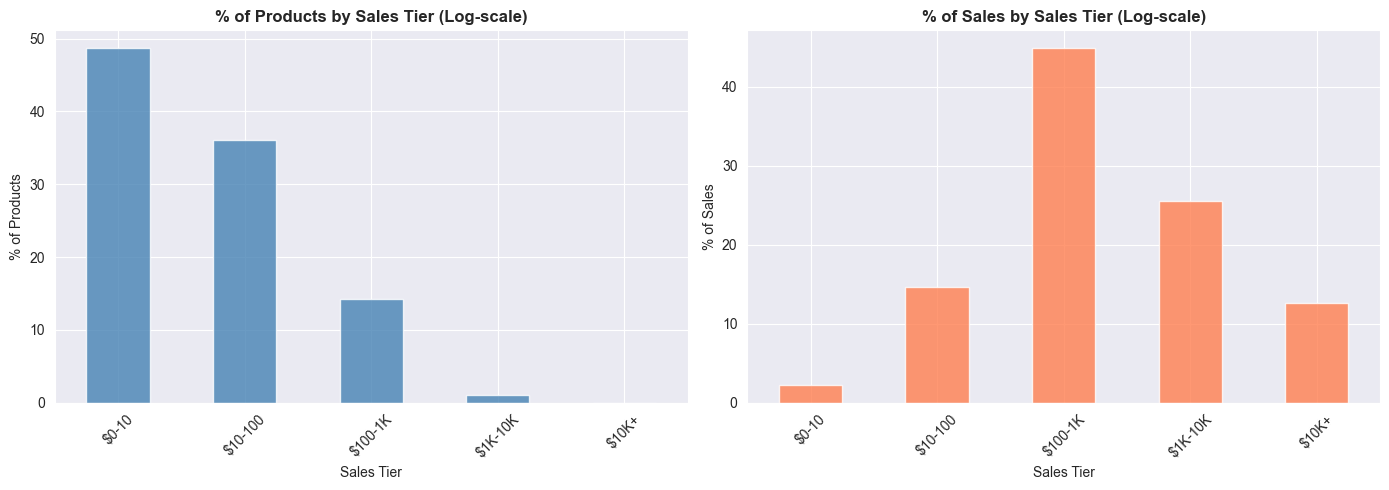

SKU TIER ANALYSIS (Log-scale Bins)
| sales_tier   |   n_products |      total_sales |   avg_households |   pct_products |   pct_sales |
|:-------------|-------------:|-----------------:|-----------------:|---------------:|------------:|
| $0-10        |        44735 | 184037           |             1.48 |          48.68 |        2.28 |
| $10-100      |        33128 |      1.1832e+06  |             9    |          36.05 |       14.68 |
| $100-1K      |        13086 |      3.61565e+06 |            57.43 |          14.24 |       44.87 |
| $1K-10K      |          929 |      2.05738e+06 |           273.35 |           1.01 |       25.53 |
| $10K+        |           27 |      1.01717e+06 |           929.52 |           0.03 |       12.62 |


Long-tail products (contributing bottom 20% of sales):
  Count: 92,015 products (100.0%)
  Avg sales: $87.57


In [56]:
# SKU Rationalization: Product sales tiers (log-scale bins)
# Log-scale bins are natural for Pareto-distributed sales data

log_bins = [0, 10, 100, 1000, 10000, np.inf]
log_labels = ['$0-10', '$10-100', '$100-1K', '$1K-10K', '$10K+']

product_sales_sorted = product_sales_sorted.assign(
    sales_tier=lambda x: pd.cut(x['total_sales'], bins=log_bins, labels=log_labels)
)

tier_summary = (
    product_sales_sorted
    .groupby('sales_tier', observed=True)
    .agg(
        n_products=('PRODUCT_ID', 'count'),
        total_sales=('total_sales', 'sum'),
        avg_households=('n_households', 'mean')
    )
    .assign(
        pct_products=lambda x: x['n_products'] / x['n_products'].sum() * 100,
        pct_sales=lambda x: x['total_sales'] / x['total_sales'].sum() * 100
    )
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Products by tier
tier_summary['pct_products'].plot(kind='bar', ax=axes[0], color='steelblue', alpha=0.8)
axes[0].set_title('% of Products by Sales Tier (Log-scale)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Sales Tier')
axes[0].set_ylabel('% of Products')
axes[0].tick_params(axis='x', rotation=45)

# Sales by tier
tier_summary['pct_sales'].plot(kind='bar', ax=axes[1], color='coral', alpha=0.8)
axes[1].set_title('% of Sales by Sales Tier (Log-scale)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Sales Tier')
axes[1].set_ylabel('% of Sales')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("="*60)
print("SKU TIER ANALYSIS (Log-scale Bins)")
print("="*60)
print(tier_summary.round(2).to_markdown())

# Long-tail products (contributing bottom 20% of sales)
long_tail_threshold = product_sales_sorted[product_sales_sorted['cumsum_pct'] <= 20]['total_sales'].max()
long_tail_products = product_sales_sorted[product_sales_sorted['total_sales'] <= long_tail_threshold]
print(f"\n\nLong-tail products (contributing bottom 20% of sales):")
print(f"  Count: {len(long_tail_products):,} products ({len(long_tail_products)/len(product_sales_sorted)*100:.1f}%)")
print(f"  Avg sales: ${long_tail_products['total_sales'].mean():.2f}")

**Summary: Product Concentration**
- **Pareto effect:** Top ~20% products drive ~80% of sales
- **Long-tail:** ~80% of products contribute only ~20% of total sales
- **SKU tiers (log-scale):** Geometric bins reveal natural sales distribution
  - Most products clustered in low-sales tiers ($0-100)
  - Few products in high-sales tiers ($10K+) but drive bulk of revenue
- **Rationalization opportunity:** Large portion of catalog has minimal sales contribution

#### 3.5 Customer-Category Relationship

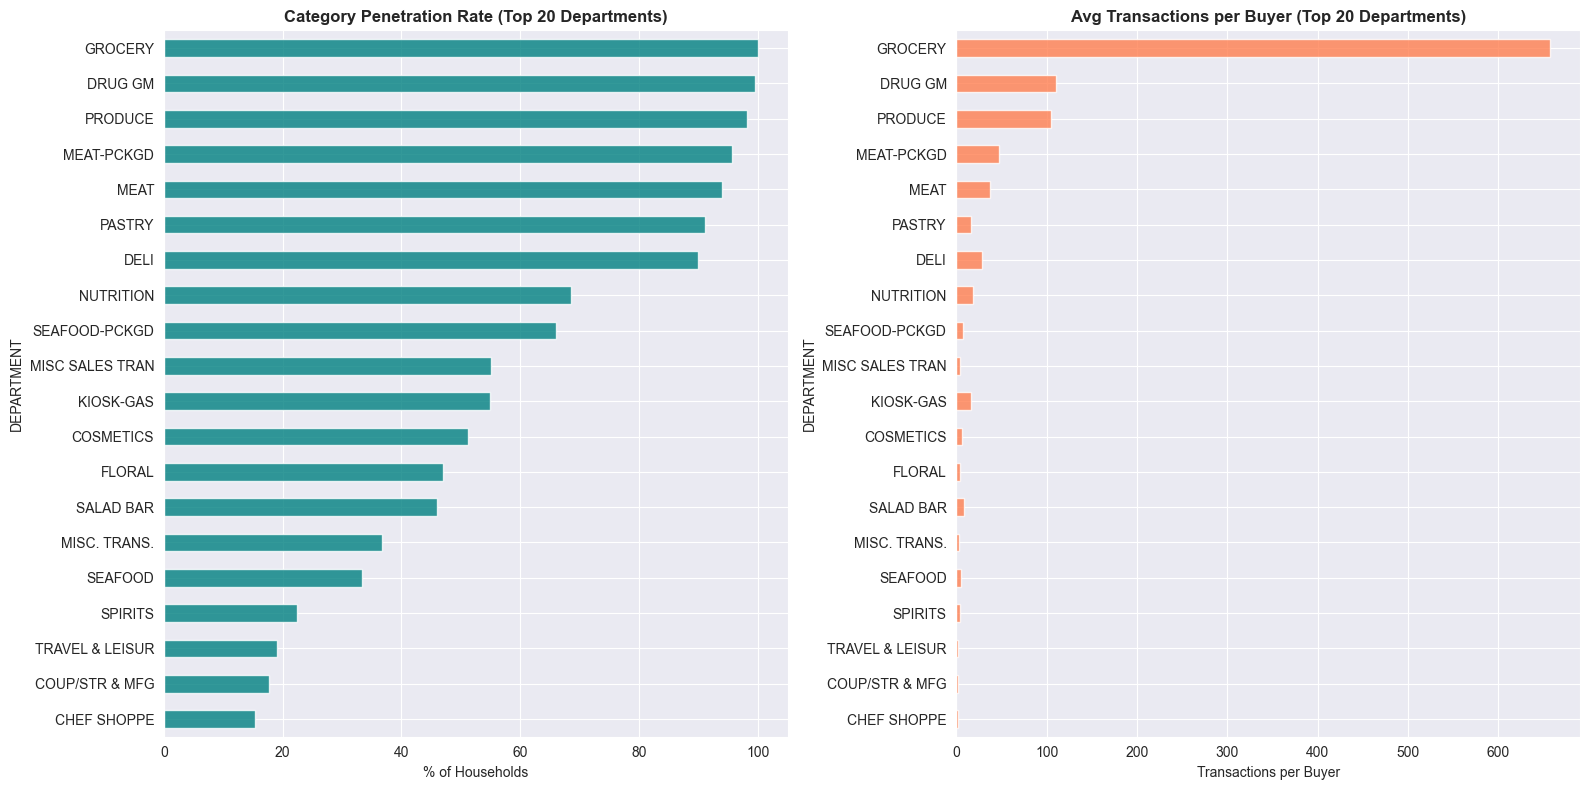

CATEGORY PENETRATION (Total households: 2,500)
| DEPARTMENT      |   unique_households |   total_transactions |      total_sales |   penetration_rate |   transactions_per_buyer |   sales_per_buyer |
|:----------------|--------------------:|---------------------:|-----------------:|-------------------:|-------------------------:|------------------:|
| GROCERY         |                2500 |           1.6435e+06 |      4.09381e+06 |             100    |                   657.4  |           1637.52 |
| DRUG GM         |                2490 |      275887          |      1.05535e+06 |              99.6  |                   110.8  |            423.84 |
| PRODUCE         |                2456 |      255906          | 557438           |              98.24 |                   104.2  |            226.97 |
| MEAT-PCKGD      |                2392 |      111730          | 412426           |              95.68 |                    46.71 |            172.42 |
| MEAT            |                2351 |

In [55]:
# Category Penetration using utils/plots.py
total_households = df_trans['household_key'].nunique()

dept_penetration = (
    df_trans_product
    .groupby('DEPARTMENT')
    .agg(
        unique_households=('household_key', 'nunique'),
        total_transactions=('household_key', 'size'),
        total_sales=('SALES_VALUE', 'sum')
    )
    .assign(
        penetration_rate=lambda x: x['unique_households'] / total_households * 100,
        transactions_per_buyer=lambda x: x['total_transactions'] / x['unique_households'],
        sales_per_buyer=lambda x: x['total_sales'] / x['unique_households']
    )
    .sort_values('penetration_rate', ascending=False)
)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

config1 = BarHConfig(title='Category Penetration Rate (Top 20 Departments)', xlabel='% of Households', color='teal', n=20)
plot_top_n_barh(axes[0], dept_penetration['penetration_rate'], config1)

config2 = BarHConfig(title='Avg Transactions per Buyer (Top 20 Departments)', xlabel='Transactions per Buyer', color='coral', n=20)
plot_top_n_barh(axes[1], dept_penetration['transactions_per_buyer'], config2)

plt.tight_layout()
plt.show()

print("="*60)
print(f"CATEGORY PENETRATION (Total households: {total_households:,})")
print("="*60)
print(dept_penetration.head(15).round(2).to_markdown())

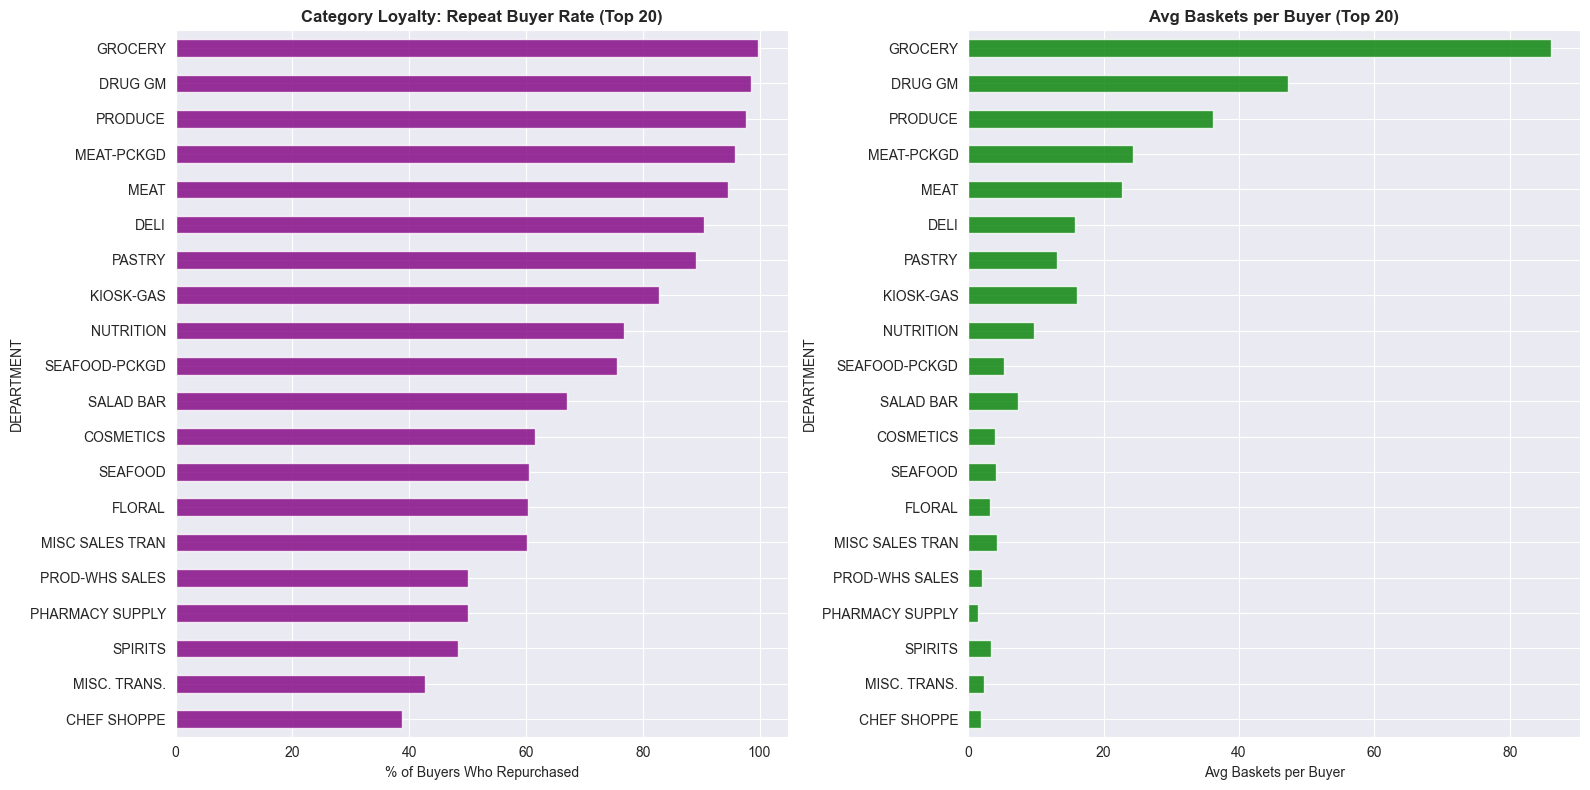

CATEGORY LOYALTY (Top 15 by Repeat Buyer Rate)
| DEPARTMENT      |   total_buyers |   repeat_buyers |   avg_baskets_per_buyer |   avg_spent_per_buyer |   repeat_buyer_rate |
|:----------------|---------------:|----------------:|------------------------:|----------------------:|--------------------:|
| GROCERY         |           2500 |            2495 |                   86.07 |               1637.52 |               99.8  |
| DRUG GM         |           2490 |            2452 |                   47.31 |                423.84 |               98.47 |
| PRODUCE         |           2456 |            2397 |                   36.21 |                226.97 |               97.6  |
| MEAT-PCKGD      |           2392 |            2290 |                   24.41 |                172.42 |               95.74 |
| MEAT            |           2351 |            2224 |                   22.69 |                233.43 |               94.6  |
| DELI            |           2248 |            2035 |          

In [57]:
# Category Loyalty using utils/plots.py
dept_household_purchases = (
    df_trans_product
    .groupby(['DEPARTMENT', 'household_key'])
    .agg(
        n_baskets=('BASKET_ID', 'nunique'),
        n_transactions=('household_key', 'size'),
        total_spent=('SALES_VALUE', 'sum')
    )
    .reset_index()
)

dept_loyalty = (
    dept_household_purchases
    .assign(is_repeat_buyer=lambda x: (x['n_baskets'] > 1).astype(int))
    .groupby('DEPARTMENT')
    .agg(
        total_buyers=('household_key', 'nunique'),
        repeat_buyers=('is_repeat_buyer', 'sum'),
        avg_baskets_per_buyer=('n_baskets', 'mean'),
        avg_spent_per_buyer=('total_spent', 'mean')
    )
    .assign(repeat_buyer_rate=lambda x: x['repeat_buyers'] / x['total_buyers'] * 100)
    .sort_values('repeat_buyer_rate', ascending=False)
)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

config1 = BarHConfig(title='Category Loyalty: Repeat Buyer Rate (Top 20)', xlabel='% of Buyers Who Repurchased', color='purple', n=20)
plot_top_n_barh(axes[0], dept_loyalty['repeat_buyer_rate'], config1)

config2 = BarHConfig(title='Avg Baskets per Buyer (Top 20)', xlabel='Avg Baskets per Buyer', color='green', n=20)
plot_top_n_barh(axes[1], dept_loyalty['avg_baskets_per_buyer'], config2)

plt.tight_layout()
plt.show()

print("="*60)
print("CATEGORY LOYALTY (Top 15 by Repeat Buyer Rate)")
print("="*60)
print(dept_loyalty.head(15).round(2).to_markdown())

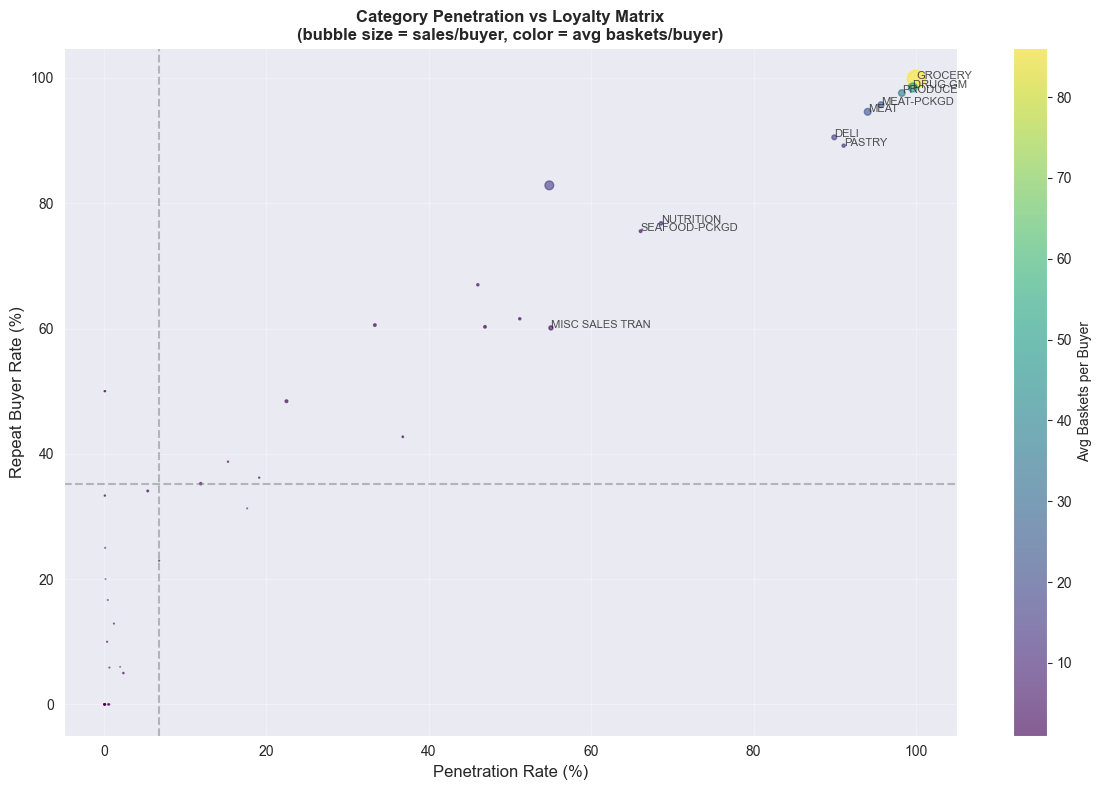

PENETRATION-LOYALTY QUADRANT ANALYSIS

Median penetration: 6.8%
Median repeat buyer rate: 35.2%

High Pen / High Loyalty (Stars): 20 departments
  Examples: GROCERY, DRUG GM, PRODUCE

High Pen / Low Loyalty (Opportunity): 2 departments
  Examples: COUP/STR & MFG, FROZEN GROCERY

Low Pen / High Loyalty (Niche): 2 departments
  Examples: PHARMACY SUPPLY, PROD-WHS SALES

Low Pen / Low Loyalty (Weak): 19 departments
  Examples: RESTAURANT, AUTOMOTIVE, DAIRY DELI


In [58]:
# Penetration vs Loyalty Matrix using utils/plots.py
dept_matrix = dept_penetration[['penetration_rate', 'sales_per_buyer']].join(
    dept_loyalty[['repeat_buyer_rate', 'avg_baskets_per_buyer']]
)

fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(
    dept_matrix['penetration_rate'],
    dept_matrix['repeat_buyer_rate'],
    s=dept_matrix['sales_per_buyer'] / 10,  # size by sales per buyer
    alpha=0.6,
    c=dept_matrix['avg_baskets_per_buyer'],
    cmap='viridis'
)

# Add labels for top departments
top_depts = dept_matrix.nlargest(10, 'penetration_rate').index.tolist()
for dept in top_depts:
    ax.annotate(dept, (dept_matrix.loc[dept, 'penetration_rate'], 
                       dept_matrix.loc[dept, 'repeat_buyer_rate']),
                fontsize=8, alpha=0.8)

# Add quadrant lines
ax.axvline(x=dept_matrix['penetration_rate'].median(), color='gray', linestyle='--', alpha=0.5)
ax.axhline(y=dept_matrix['repeat_buyer_rate'].median(), color='gray', linestyle='--', alpha=0.5)

ax.set_xlabel('Penetration Rate (%)', fontsize=12)
ax.set_ylabel('Repeat Buyer Rate (%)', fontsize=12)
ax.set_title('Category Penetration vs Loyalty Matrix\n(bubble size = sales/buyer, color = avg baskets/buyer)', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.colorbar(scatter, label='Avg Baskets per Buyer')
plt.tight_layout()
plt.show()

# Quadrant analysis
median_pen = dept_matrix['penetration_rate'].median()
median_loyalty = dept_matrix['repeat_buyer_rate'].median()

print("="*60)
print("PENETRATION-LOYALTY QUADRANT ANALYSIS")
print("="*60)
print(f"\nMedian penetration: {median_pen:.1f}%")
print(f"Median repeat buyer rate: {median_loyalty:.1f}%")

quadrants = {
    'High Pen / High Loyalty (Stars)': dept_matrix[(dept_matrix['penetration_rate'] >= median_pen) & (dept_matrix['repeat_buyer_rate'] >= median_loyalty)],
    'High Pen / Low Loyalty (Opportunity)': dept_matrix[(dept_matrix['penetration_rate'] >= median_pen) & (dept_matrix['repeat_buyer_rate'] < median_loyalty)],
    'Low Pen / High Loyalty (Niche)': dept_matrix[(dept_matrix['penetration_rate'] < median_pen) & (dept_matrix['repeat_buyer_rate'] >= median_loyalty)],
    'Low Pen / Low Loyalty (Weak)': dept_matrix[(dept_matrix['penetration_rate'] < median_pen) & (dept_matrix['repeat_buyer_rate'] < median_loyalty)]
}

for quadrant, df in quadrants.items():
    print(f"\n{quadrant}: {len(df)} departments")
    if len(df) > 0:
        print(f"  Examples: {', '.join(df.head(3).index.tolist())}")

**Summary: Customer-Category Relationship**
- **Category Penetration:** GROCERY (99%+), DRUG GM, PRODUCE, MEAT are near-universal
- **Category Loyalty:** High repeat rates in GROCERY, PRODUCE, MEAT; lower in COSMETICS, VIDEO
- **Penetration-Loyalty Matrix:**
  - **Stars** (High/High): GROCERY, PRODUCE, MEAT - core categories
  - **Opportunity** (High Pen/Low Loyalty): potential for engagement improvement
  - **Niche** (Low Pen/High Loyalty): specialty categories with devoted buyers
  - **Weak** (Low/Low): categories needing strategic review

#### 3.6 Price Analysis

PRICE DISTRIBUTION BY DEPARTMENT
| DEPARTMENT      |   n_transactions |   mean_price |   median_price |   std_price |   min_price |   max_price |   avg_discount_rate |   cv_price |   price_range |
|:----------------|-----------------:|-------------:|---------------:|------------:|------------:|------------:|--------------------:|-----------:|--------------:|
| GROCERY         |       1.6435e+06 |        2.071 |          1.67  |       1.721 |       0     |      78.5   |               0.148 |      0.831 |        78.5   |
| DRUG GM         |  275887          |        3.342 |          2.19  |       4.801 |       0     |     499.99  |               0.096 |      1.436 |       499.99  |
| PRODUCE         |  255906          |        1.933 |          1.65  |       1.355 |       0     |      32.42  |               0.081 |      0.701 |        32.42  |
| MEAT-PCKGD      |  111730          |        2.992 |          2.5   |       1.853 |       0     |      16.99  |               0.2   |      0.619 |

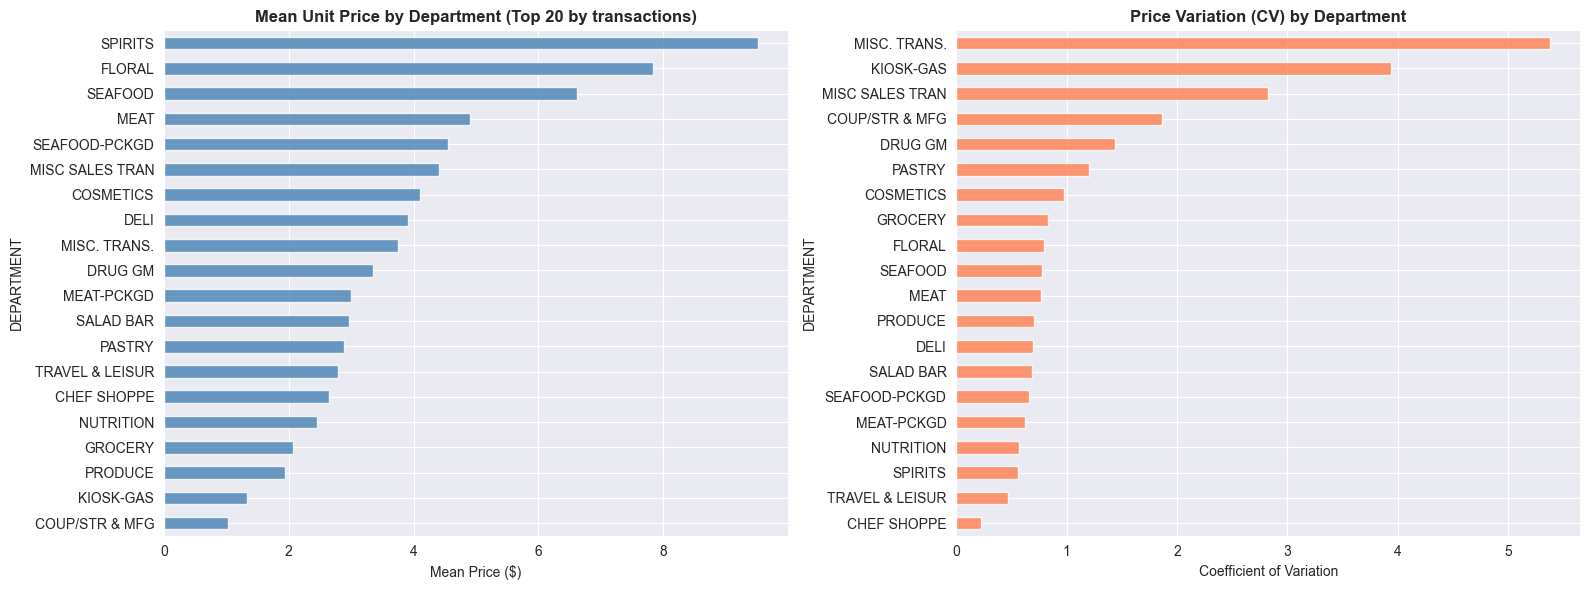

In [59]:
# Calculate unit price for each transaction
df_trans_price = df_trans_product.assign(
    unit_price=lambda x: x['SALES_VALUE'] / x['QUANTITY'],
    regular_price=lambda x: (x['SALES_VALUE'] + x['RETAIL_DISC']) / x['QUANTITY'],
    discount_rate=lambda x: x['RETAIL_DISC'] / (x['SALES_VALUE'] + x['RETAIL_DISC'])
)

# Price distribution by department
dept_price = (
    df_trans_price
    .groupby('DEPARTMENT')
    .agg(
        n_transactions=('unit_price', 'count'),
        mean_price=('unit_price', 'mean'),
        median_price=('unit_price', 'median'),
        std_price=('unit_price', 'std'),
        min_price=('unit_price', 'min'),
        max_price=('unit_price', 'max'),
        avg_discount_rate=('discount_rate', 'mean')
    )
    .assign(
        cv_price=lambda x: x['std_price'] / x['mean_price'],  # coefficient of variation
        price_range=lambda x: x['max_price'] - x['min_price']
    )
    .sort_values('n_transactions', ascending=False)
)

print("="*80)
print("PRICE DISTRIBUTION BY DEPARTMENT")
print("="*80)
print(dept_price.head(15).round(3).to_markdown())

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Mean price by department
dept_price.head(20)['mean_price'].sort_values().plot(kind='barh', ax=axes[0], color='steelblue', alpha=0.8)
axes[0].set_title('Mean Unit Price by Department (Top 20 by transactions)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Mean Price ($)')

# Price variation (CV) by department
dept_price.head(20)['cv_price'].sort_values().plot(kind='barh', ax=axes[1], color='coral', alpha=0.8)
axes[1].set_title('Price Variation (CV) by Department', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Coefficient of Variation')

plt.tight_layout()
plt.show()

WITHIN-PRODUCT PRICE VARIATION
Products with ≥10 transactions: 26,717
Products with price variation (CV > 0): 25,052 (93.8%)

Mean CV across products: 0.146
Median price range %: 41.7%


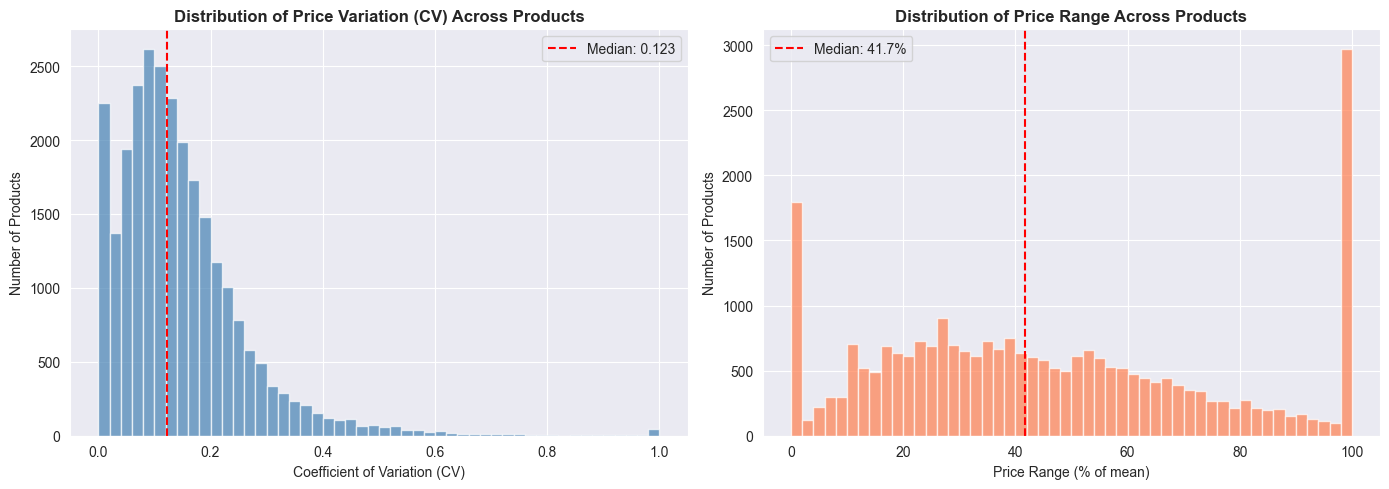

In [60]:
# Price variation within products (same product, different prices over time)
product_price_variation = (
    df_trans_price
    .groupby('PRODUCT_ID')
    .agg(
        n_transactions=('unit_price', 'count'),
        mean_price=('unit_price', 'mean'),
        std_price=('unit_price', 'std'),
        min_price=('unit_price', 'min'),
        max_price=('unit_price', 'max')
    )
    .assign(
        cv_price=lambda x: x['std_price'] / x['mean_price'],
        price_range_pct=lambda x: (x['max_price'] - x['min_price']) / x['mean_price'] * 100
    )
)

# Filter products with enough transactions
product_price_var_filtered = product_price_variation[product_price_variation['n_transactions'] >= 10]

print("="*60)
print("WITHIN-PRODUCT PRICE VARIATION")
print("="*60)
print(f"Products with ≥10 transactions: {len(product_price_var_filtered):,}")
print(f"Products with price variation (CV > 0): {(product_price_var_filtered['cv_price'] > 0).sum():,} ({(product_price_var_filtered['cv_price'] > 0).mean()*100:.1f}%)")
print(f"\nMean CV across products: {product_price_var_filtered['cv_price'].mean():.3f}")
print(f"Median price range %: {product_price_var_filtered['price_range_pct'].median():.1f}%")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of CV
axes[0].hist(product_price_var_filtered['cv_price'].clip(upper=1), bins=50, color='steelblue', alpha=0.7, edgecolor='white')
axes[0].set_xlabel('Coefficient of Variation (CV)')
axes[0].set_ylabel('Number of Products')
axes[0].set_title('Distribution of Price Variation (CV) Across Products', fontsize=12, fontweight='bold')
axes[0].axvline(product_price_var_filtered['cv_price'].median(), color='red', linestyle='--', label=f"Median: {product_price_var_filtered['cv_price'].median():.3f}")
axes[0].legend()

# Distribution of price range %
axes[1].hist(product_price_var_filtered['price_range_pct'].clip(upper=100), bins=50, color='coral', alpha=0.7, edgecolor='white')
axes[1].set_xlabel('Price Range (% of mean)')
axes[1].set_ylabel('Number of Products')
axes[1].set_title('Distribution of Price Range Across Products', fontsize=12, fontweight='bold')
axes[1].axvline(product_price_var_filtered['price_range_pct'].median(), color='red', linestyle='--', label=f"Median: {product_price_var_filtered['price_range_pct'].median():.1f}%")
axes[1].legend()

plt.tight_layout()
plt.show()

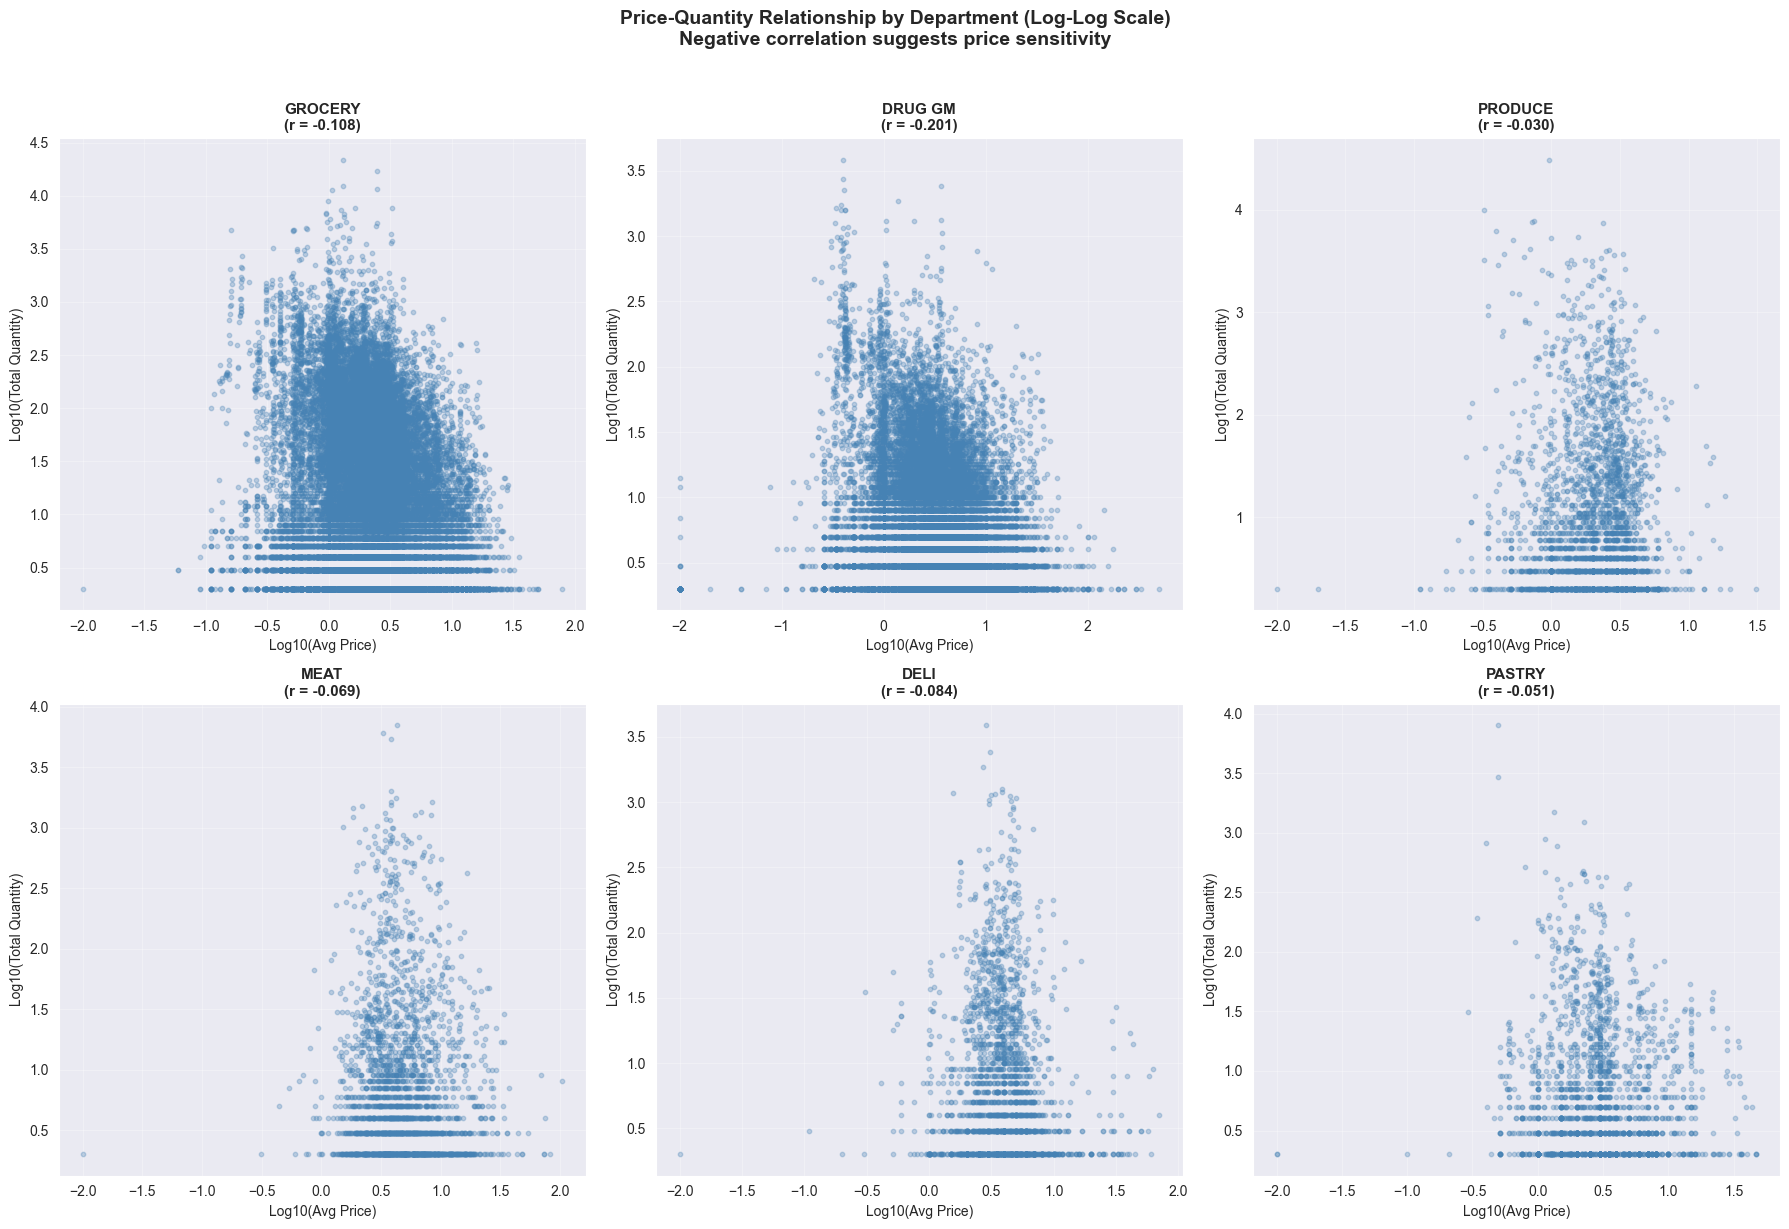

PRICE-QUANTITY CORRELATION BY DEPARTMENT (Log-Log)
(Negative = higher price → lower quantity, i.e., price sensitive)
| DEPARTMENT      |   n_products |   log_price_qty_corr |
|:----------------|-------------:|---------------------:|
| MISC SALES TRAN |           86 |               -0.855 |
| RESTAURANT      |           98 |               -0.393 |
| SALAD BAR       |           46 |               -0.33  |
| SPIRITS         |          375 |               -0.249 |
| MISC. TRANS.    |          467 |               -0.229 |
| DRUG GM         |        31335 |               -0.201 |
| NUTRITION       |         2907 |               -0.185 |
| COSMETICS       |         2938 |               -0.14  |
| GROCERY         |        38981 |               -0.108 |
| DELI            |         2348 |               -0.084 |
| MEAT            |         2540 |               -0.069 |
| PASTRY          |         2146 |               -0.051 |
| PRODUCE         |         3091 |               -0.03  |
| FLORAL     

In [61]:
# Price-Quantity relationship by category (visual exploration)
# Aggregate at product level for cleaner visualization
product_pq = (
    df_trans_price
    .groupby(['PRODUCT_ID', 'DEPARTMENT'])
    .agg(
        avg_price=('unit_price', 'mean'),
        total_quantity=('QUANTITY', 'sum'),
        n_transactions=('PRODUCT_ID', 'size')
    )
    .reset_index()
)

# Select top departments for visualization
top_depts = ['GROCERY', 'DRUG GM', 'PRODUCE', 'MEAT', 'DELI', 'PASTRY']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, dept in enumerate(top_depts):
    dept_data = product_pq[product_pq['DEPARTMENT'] == dept]
    
    # Log-log scatter plot
    axes[idx].scatter(
        np.log10(dept_data['avg_price'] + 0.01),
        np.log10(dept_data['total_quantity'] + 1),
        alpha=0.3, s=10, c='steelblue'
    )
    
    # Add correlation
    valid_data = dept_data[(dept_data['avg_price'] > 0) & (dept_data['total_quantity'] > 0)]
    corr = np.corrcoef(np.log(valid_data['avg_price']), np.log(valid_data['total_quantity']))[0, 1]
    
    axes[idx].set_xlabel('Log10(Avg Price)')
    axes[idx].set_ylabel('Log10(Total Quantity)')
    axes[idx].set_title(f'{dept}\n(r = {corr:.3f})', fontsize=11, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Price-Quantity Relationship by Department (Log-Log Scale)\nNegative correlation suggests price sensitivity', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Correlation summary across all departments
dept_corr = []
for dept in product_pq['DEPARTMENT'].unique():
    dept_data = product_pq[product_pq['DEPARTMENT'] == dept]
    valid_data = dept_data[(dept_data['avg_price'] > 0) & (dept_data['total_quantity'] > 0)]
    if len(valid_data) >= 30:
        corr = np.corrcoef(np.log(valid_data['avg_price']), np.log(valid_data['total_quantity']))[0, 1]
        dept_corr.append({'DEPARTMENT': dept, 'n_products': len(valid_data), 'log_price_qty_corr': corr})

dept_corr_df = pd.DataFrame(dept_corr).sort_values('log_price_qty_corr')

print("="*60)
print("PRICE-QUANTITY CORRELATION BY DEPARTMENT (Log-Log)")
print("="*60)
print("(Negative = higher price → lower quantity, i.e., price sensitive)")
print(dept_corr_df.head(15).round(3).to_markdown(index=False))

**Summary: Price Analysis**
- **Price by department:** Wide range - MEAT/SEAFOOD high ($4-6), DRUG GM/GROCERY low ($2-3)
- **Price variation:** Most products show price variation over time (promotions, seasonal)
- **Price-Quantity correlation:** Negative correlation in most categories (expected demand curve)
  - Stronger negative correlation → higher price sensitivity
  - Categories with weak correlation may have inelastic demand
- **Implication:** Sufficient price variation exists for econometric elasticity estimation

#### 3.7 Discount Patterns

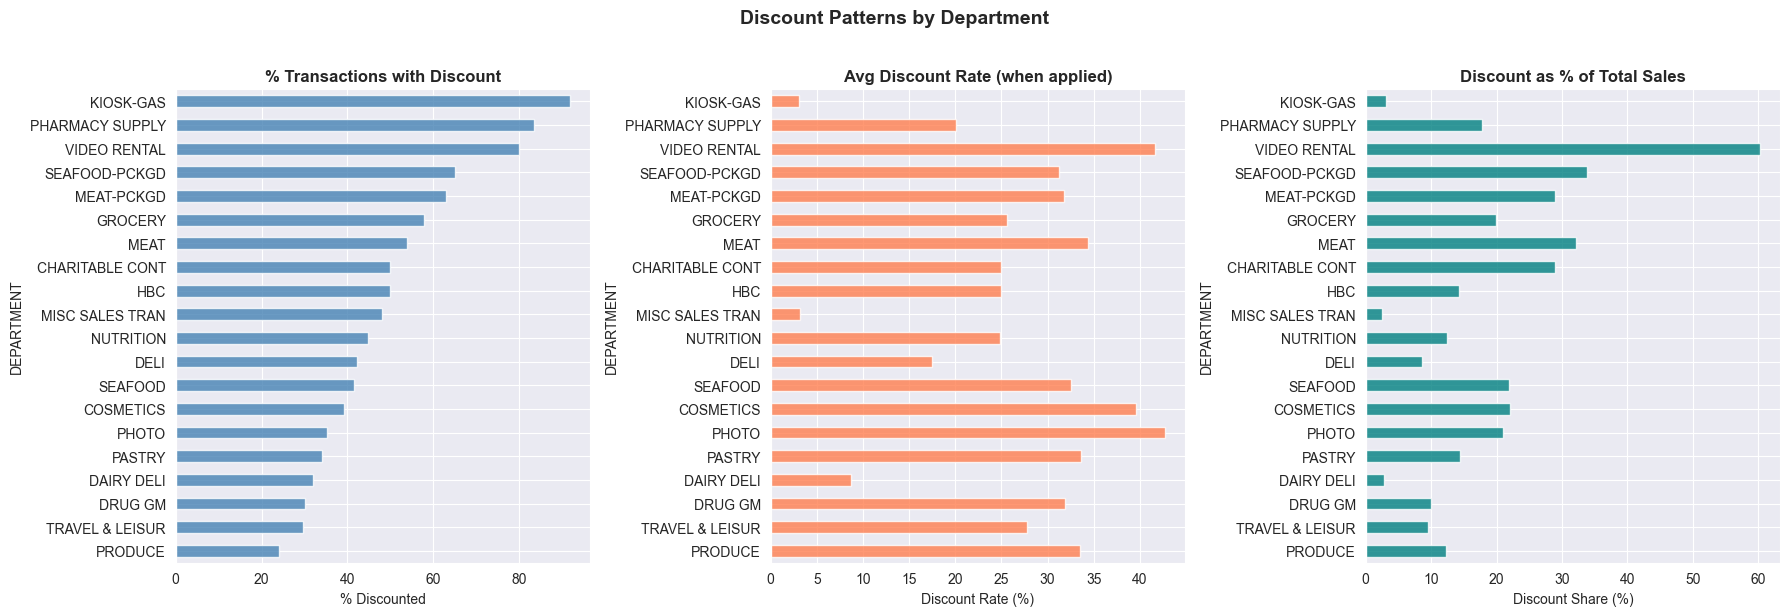

DISCOUNT PATTERNS BY DEPARTMENT (Top 15)
| DEPARTMENT      |   n_transactions |      total_sales |   total_discount |   pct_discounted |   avg_discount_when_applied |   avg_discount_rate |   discount_share |
|:----------------|-----------------:|-----------------:|-----------------:|-----------------:|----------------------------:|--------------------:|-----------------:|
| KIOSK-GAS       |   22059          | 544222           |         17225.4  |            91.87 |                        0.85 |                3.1  |             3.17 |
| PHARMACY SUPPLY |       6          |     16.92        |             3    |            83.33 |                        0.6  |               20.08 |            17.73 |
| VIDEO RENTAL    |       5          |     21.46        |            12.94 |            80    |                        3.24 |               41.6  |            60.3  |
| SEAFOOD-PCKGD   |   11180          |  63093.6         |         21385.6  |            65.09 |                        2.94 

In [62]:
# Discount patterns by category using utils/plots.py
dept_discount = (
    df_trans_price
    .groupby('DEPARTMENT')
    .agg(
        n_transactions=('PRODUCT_ID', 'size'),
        total_sales=('SALES_VALUE', 'sum'),
        total_discount=('RETAIL_DISC', 'sum'),
        pct_discounted=('RETAIL_DISC', lambda x: (x > 0).mean() * 100),
        avg_discount_when_applied=('RETAIL_DISC', lambda x: x[x > 0].mean() if (x > 0).any() else 0),
        avg_discount_rate=('discount_rate', lambda x: x[x > 0].mean() * 100 if (x > 0).any() else 0)
    )
    .assign(
        discount_share=lambda x: x['total_discount'] / x['total_sales'] * 100
    )
    .sort_values('pct_discounted', ascending=False)
)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

config1 = BarHConfig(title='% Transactions with Discount', xlabel='% Discounted', color='steelblue', n=20)
plot_top_n_barh(axes[0], dept_discount['pct_discounted'], config1)

config2 = BarHConfig(title='Avg Discount Rate (when applied)', xlabel='Discount Rate (%)', color='coral', n=20)
plot_top_n_barh(axes[1], dept_discount['avg_discount_rate'], config2)

config3 = BarHConfig(title='Discount as % of Total Sales', xlabel='Discount Share (%)', color='teal', n=20)
plot_top_n_barh(axes[2], dept_discount['discount_share'], config3)

plt.suptitle('Discount Patterns by Department', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("="*60)
print("DISCOUNT PATTERNS BY DEPARTMENT (Top 15)")
print("="*60)
print(dept_discount.head(15).round(2).to_markdown())

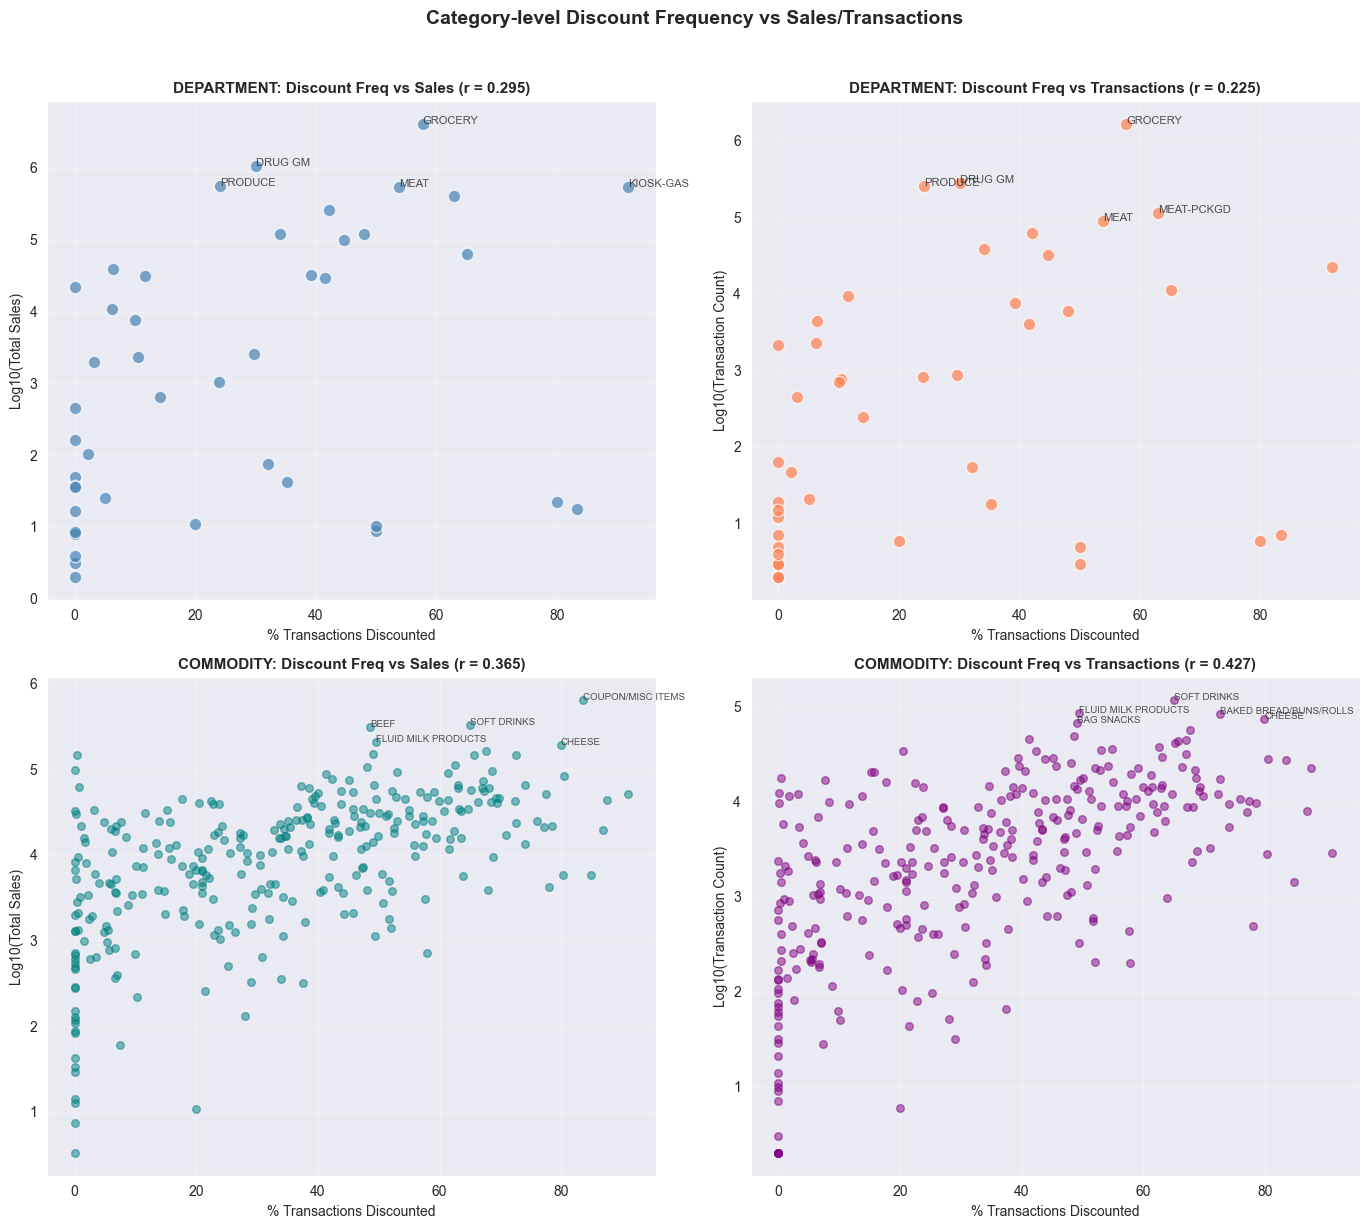

CATEGORY-LEVEL DISCOUNT-SALES CORRELATION

DEPARTMENT level (43 categories):
  Discount Freq vs Sales: r = 0.295
  Discount Freq vs Transactions: r = 0.225

COMMODITY level (307 categories):
  Discount Freq vs Sales: r = 0.365
  Discount Freq vs Transactions: r = 0.427


In [63]:
# Category-level discount rate vs sales/transactions

# By DEPARTMENT
dept_discount_sales = (
    df_trans_price
    .groupby('DEPARTMENT')
    .agg(
        n_transactions=('PRODUCT_ID', 'size'),
        total_sales=('SALES_VALUE', 'sum'),
        pct_discounted=('RETAIL_DISC', lambda x: (x > 0).mean() * 100),
        avg_discount_rate=('discount_rate', lambda x: x[x > 0].mean() * 100 if (x > 0).any() else 0)
    )
    .reset_index()
)

# By COMMODITY_DESC
commodity_discount_sales = (
    df_trans_price
    .groupby('COMMODITY_DESC')
    .agg(
        n_transactions=('PRODUCT_ID', 'size'),
        total_sales=('SALES_VALUE', 'sum'),
        pct_discounted=('RETAIL_DISC', lambda x: (x > 0).mean() * 100),
        avg_discount_rate=('discount_rate', lambda x: x[x > 0].mean() * 100 if (x > 0).any() else 0)
    )
    .reset_index()
)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Department: Discount frequency vs Sales
ax = axes[0, 0]
ax.scatter(dept_discount_sales['pct_discounted'], 
           np.log10(dept_discount_sales['total_sales'] + 1),
           s=80, alpha=0.7, c='steelblue', edgecolors='white')
corr1 = dept_discount_sales[['pct_discounted', 'total_sales']].corr().iloc[0, 1]
for _, row in dept_discount_sales.nlargest(5, 'total_sales').iterrows():
    ax.annotate(row['DEPARTMENT'], (row['pct_discounted'], np.log10(row['total_sales'] + 1)), 
                fontsize=8, alpha=0.8)
ax.set_xlabel('% Transactions Discounted')
ax.set_ylabel('Log10(Total Sales)')
ax.set_title(f'DEPARTMENT: Discount Freq vs Sales (r = {corr1:.3f})', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3)

# 2. Department: Discount frequency vs Transactions
ax = axes[0, 1]
ax.scatter(dept_discount_sales['pct_discounted'], 
           np.log10(dept_discount_sales['n_transactions'] + 1),
           s=80, alpha=0.7, c='coral', edgecolors='white')
corr2 = dept_discount_sales[['pct_discounted', 'n_transactions']].corr().iloc[0, 1]
for _, row in dept_discount_sales.nlargest(5, 'n_transactions').iterrows():
    ax.annotate(row['DEPARTMENT'], (row['pct_discounted'], np.log10(row['n_transactions'] + 1)), 
                fontsize=8, alpha=0.8)
ax.set_xlabel('% Transactions Discounted')
ax.set_ylabel('Log10(Transaction Count)')
ax.set_title(f'DEPARTMENT: Discount Freq vs Transactions (r = {corr2:.3f})', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3)

# 3. Commodity: Discount frequency vs Sales
ax = axes[1, 0]
ax.scatter(commodity_discount_sales['pct_discounted'], 
           np.log10(commodity_discount_sales['total_sales'] + 1),
           s=30, alpha=0.5, c='teal')
corr3 = commodity_discount_sales[['pct_discounted', 'total_sales']].corr().iloc[0, 1]
for _, row in commodity_discount_sales.nlargest(5, 'total_sales').iterrows():
    ax.annotate(row['COMMODITY_DESC'], (row['pct_discounted'], np.log10(row['total_sales'] + 1)), 
                fontsize=7, alpha=0.8)
ax.set_xlabel('% Transactions Discounted')
ax.set_ylabel('Log10(Total Sales)')
ax.set_title(f'COMMODITY: Discount Freq vs Sales (r = {corr3:.3f})', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3)

# 4. Commodity: Discount frequency vs Transactions
ax = axes[1, 1]
ax.scatter(commodity_discount_sales['pct_discounted'], 
           np.log10(commodity_discount_sales['n_transactions'] + 1),
           s=30, alpha=0.5, c='purple')
corr4 = commodity_discount_sales[['pct_discounted', 'n_transactions']].corr().iloc[0, 1]
for _, row in commodity_discount_sales.nlargest(5, 'n_transactions').iterrows():
    ax.annotate(row['COMMODITY_DESC'], (row['pct_discounted'], np.log10(row['n_transactions'] + 1)), 
                fontsize=7, alpha=0.8)
ax.set_xlabel('% Transactions Discounted')
ax.set_ylabel('Log10(Transaction Count)')
ax.set_title(f'COMMODITY: Discount Freq vs Transactions (r = {corr4:.3f})', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.suptitle('Category-level Discount Frequency vs Sales/Transactions', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("="*60)
print("CATEGORY-LEVEL DISCOUNT-SALES CORRELATION")
print("="*60)
print(f"\nDEPARTMENT level ({len(dept_discount_sales)} categories):")
print(f"  Discount Freq vs Sales: r = {corr1:.3f}")
print(f"  Discount Freq vs Transactions: r = {corr2:.3f}")
print(f"\nCOMMODITY level ({len(commodity_discount_sales)} categories):")
print(f"  Discount Freq vs Sales: r = {corr3:.3f}")
print(f"  Discount Freq vs Transactions: r = {corr4:.3f}")

**Summary: Discount Patterns**
- **Discount frequency:** Varies widely by category (some >60%, others <20%)
- **Discount depth:** Avg discount rate when applied differs by department
- **Discount-Sales relationship:**
  - Department/Commodity with higher discount frequency tend to have higher sales/transactions
  - Positive correlation suggests discounts drive volume (or high-volume categories use more promotions)
  - Causal interpretation requires econometric analysis (endogeneity concern)
- **Implication:** Category-level discount sensitivity should be estimated with proper controls

---

### Product Analysis: Key Takeaways

1. **Product Hierarchy:** 92K products across 44 departments, 308 commodities. GROCERY dominates (51% of sales).

2. **Brand Strategy:** 85% National, 15% Private label. Private label strong in PASTRY (64%), DELI (46%); weak in COSMETICS, VIDEO.

3. **Concentration:** Strong Pareto - top 20% products = 80% sales. Top 57 manufacturers (1.5%) = 80% sales.

4. **Repeat Purchase:** Consumables (MILK, BREAD) have high repeat rates; durables (COSMETICS) low.

5. **Category Health:**
   - **Stars:** GROCERY, PRODUCE, MEAT (high penetration + high loyalty)
   - **Growth Opportunity:** Categories with high reach but low repeat rates
   - **SKU Rationalization:** Long-tail products (~80%) contribute minimal sales

6. **Price Characteristics:**
   - Wide price variation within products (promotions, seasonal)
   - Negative price-quantity correlation in most categories (demand curve)
   - Sufficient price variation for econometric elasticity estimation

7. **Discount Patterns:**
   - Category heterogeneity in discount frequency and depth
   - Positive discount-sales correlation (high-volume categories use more promotions)
   - Causal discount effect requires panel regression with controls